In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

In [2]:
exp_dirs = ["expo_1k_shots", "expo_5k_shots", "expo_10k_shots"]

In [3]:
colors = {
    "vanilla": sns.color_palette()[0],
    "cc": sns.color_palette()[1],
    "sw": sns.color_palette()[2],
    "cc_sw": sns.color_palette()[3],
    
    "cc_all": sns.color_palette()[4],
    "sw_without": sns.color_palette()[2],
    "sw_after": sns.color_palette()[3],
}

legend = {
    "vanilla": "Naive",
    "cc": "Only Circuit Cutting",
    "sw": "Only Shot-Wise",
    "cc_sw": "Cut&Shoot",
    
    "cc_all": "Circuit Cutting",
    "sw_without": "Shot-Wise (Without Circuit Cutting)",
    "sw_after": "Shot-Wise (After Circuit Cutting)",
}

dir = "./experiments_results/"

paths = [dir + exp_dir + "/" for exp_dir in exp_dirs]
paths

['./experiments_results/expo_1k_shots/',
 './experiments_results/expo_5k_shots/',
 './experiments_results/expo_10k_shots/']

In [4]:
plots_dir = "./plots/"

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [5]:
def parse_data(data, file, path, _dir):
    
    dispatch = []
    for _, backends_data in data["stats"]["dispatch"].items():
        for _, circuits_data in backends_data.items():
            for _,shots in circuits_data:
                dispatch.append(shots)
                
    results = data["results"]
    if type(results) == dict:
        _results = None
        for _,b_d in results.items():
            for _, c_d in b_d.items():
                for _, r in c_d.items():
                    _results = r
        results = _results
        
    error = data["error"]
    if type(error) == dict:
        _error = None
        for _,b_d in error.items():
            for _, c_d in b_d.items():
                for _, r in c_d.items():
                    _error = r
        error = _error
        
    error = abs(error) if error != None else None
            
    
    return {
            "id": file,
            "exp": path,
            "operation": _dir,
            "shots": data["params"]["shots"],
            "backends": data["params"]["backends"],
            "backends_len": len(data["params"]["backends"]),
            "cut_strategy": data["params"]["cut_strategy"] if "cut_strategy" in data["params"] else None,
            "shots_allocation": data["params"]["shots_allocation"] if "shots_allocation" in data["params"] else None,
            "shot_wise_policy": data["params"]["shot_wise_policy"] if "shot_wise_policy" in data["params"] else None,
            "circuit_name": data["params"]["circuit_name"],
            "qubits": data["params"]["n_qubits"],
            "results": results,
            "error": error,
            "time_cutting": data["times"]["time_cutting"] if "time_cutting" in data["times"] else None,
            "time_allocation": data["times"]["time_allocation"] if "time_allocation" in data["times"] else None,
            "time_dispatch": data["times"]["time_dispatch"],
            "time_execution": data["times"]["time_execution"],
            "time_synchronization": data["times"]["time_synchronization"],
            "time_counts": data["times"]["time_counts"],
            "time_merge": data["times"]["time_merge"] if "time_merge" in data["times"] else None,
            "time_expected_values": data["times"]["time_expected_values"] if "time_expected_values" in data["times"] else None,
            "time_sew": data["times"]["time_sew"] if "time_sew" in data["times"] else None,
            "time_total": data["times"]["time_total"],
            "depth": data["stats"]["circuit_stats"]["depth"],
            "num_gates": data["stats"]["circuit_stats"]["num_gates"],
            "2q_depth": data["stats"]["circuit_stats"]["2q_depth"],
            "num_1q_gates": data["stats"]["circuit_stats"]["num_1q_gates"],
            "num_2q_gates": data["stats"]["circuit_stats"]["num_2q_gates"],
            "num_measurements": data["stats"]["circuit_stats"]["num_measurements"],
            "num_fragments": data["stats"]["cut_info"]["num_fragments"] if "cut_info" in data["stats"] else None,
            "num_variations": data["stats"]["cut_info"]["num_variations"] if "cut_info" in data["stats"] else None,
            "min_fragments_qubits": min(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "max_fragments_qubits": max(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "avg_fragments_qubits": np.mean(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "median_fragments_qubits": np.median(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "std_fragments_qubits": np.std(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "min_variations": min(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "max_variations": max(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "avg_variations": np.mean(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "median_variations": np.median(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "std_variations": np.std(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "min_shots": min(dispatch),
            "max_shots": max(dispatch),
            "avg_shots": np.mean(dispatch),
            "median_shots": np.median(dispatch),
            "std_shots": np.std(dispatch),
            "min_shots_norm": min(dispatch) / data["params"]["shots"],
            "max_shots_norm": max(dispatch) / data["params"]["shots"],
            "avg_shots_norm": np.mean(dispatch) / data["params"]["shots"],
            "median_shots_norm": np.median(dispatch) / data["params"]["shots"],
            "std_shots_norm": np.std(dispatch) / data["params"]["shots"],
            "error_norm": error / data["params"]["shots"] if error != None else None,
        }

In [6]:
exp_dfs = []

for path in paths:
    _df = []
    for _dir in ["vanilla", "cc", "sw", "cc_sw"]:
        dir_path = path + _dir + "/"
        for file in os.listdir(dir_path):
            with open(dir_path + file) as f:
                data = json.load(f)
                if data["params"]["operation"] != _dir:
                    raise Exception(f"Operation is not the same as the directory name: {data['operation']} != {_dir} in {path}/{file}")
                _df.append(parse_data(data, file, path, _dir))
    exp_dfs.append(pd.DataFrame(_df))
    
exp_dfs

[                                                     id  \
 0             14281_q10_vanilla_n4_r2_k2_p1_s18_b0.json   
 1              8929_q10_vanilla_n4_r2_k2_p1_s27_b3.json   
 2             16071_q10_vanilla_n4_r2_k2_p1_s15_b5.json   
 3               1786_q14_vanilla_n4_r3_k1_p1_s2_b0.json   
 4              5358_q14_vanilla_n4_r3_k1_p1_s11_b2.json   
 ...                                                 ...   
 25021  10099_q10_cc_sw_n4_r2_k2_p1_s27_b2_b4_b5_b6.json   
 25022  15325_q10_cc_sw_n4_r2_k2_p1_s18_b1_b2_b4_b5.json   
 25023  16995_q10_cc_sw_n4_r2_k2_p1_s15_b0_b2_b4_b6.json   
 25024  25937_q5_cc_sw_n2_r2_k1_p1_s149_b0_b2_b5_b7.json   
 25025  13491_q10_cc_sw_n4_r2_k2_p1_s22_b0_b4_b5_b6.json   
 
                                         exp operation  shots  \
 0      ./experiments_results/expo_1k_shots/   vanilla   1000   
 1      ./experiments_results/expo_1k_shots/   vanilla   1000   
 2      ./experiments_results/expo_1k_shots/   vanilla   1000   
 3      ./experime

In [7]:
df = pd.concat(exp_dfs)
df = df.reset_index(drop=True)
df

,id,exp,operation,shots,backends,backends_len,cut_strategy,shots_allocation,shot_wise_policy,circuit_name,...,max_shots,avg_shots,median_shots,std_shots,min_shots_norm,max_shots_norm,avg_shots_norm,median_shots_norm,std_shots_norm,error_norm
0,14281_q10_vanilla_n4_r2_k2_p1_s18_b0.json,./experiments_results/expo_1k_shots/,vanilla,1000,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r2_k2_p1_s18,...,1000,1000.000,1000.0,0.000000,1.0000,1.0000,1.000000,1.00000,0.000000,6.787559e-05
1,8929_q10_vanilla_n4_r2_k2_p1_s27_b3.json,./experiments_results/expo_1k_shots/,vanilla,1000,"[[ibm_aer, aer.fake_sherbrooke]]",1,None,None,None,n4_r2_k2_p1_s27,...,1000,1000.000,1000.0,0.000000,1.0000,1.0000,1.000000,1.00000,0.000000,3.800953e-05
2,16071_q10_vanilla_n4_r2_k2_p1_s15_b5.json,./experiments_results/expo_1k_shots/,vanilla,1000,"[[ibm_aer, aer.fake_kawasaki]]",1,None,None,None,n4_r2_k2_p1_s15,...,1000,1000.000,1000.0,0.000000,1.0000,1.0000,1.000000,1.00000,0.000000,1.999509e-05
3,1786_q14_vanilla_n4_r3_k1_p1_s2_b0.json,./experiments_results/expo_1k_shots/,vanilla,1000,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r3_k1_p1_s2,...,1000,1000.000,1000.0,0.000000,1.0000,1.0000,1.000000,1.00000,0.000000,1.564686e-09
4,5358_q14_vanilla_n4_r3_k1_p1_s11_b2.json,./experiments_results/expo_1k_shots/,vanilla,1000,"[[ibm_aer, aer.fake_osaka]]",1,None,None,None,n4_r3_k1_p1_s11,...,1000,1000.000,1000.0,0.000000,1.0000,1.0000,1.000000,1.00000,0.000000,6.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75949,10099_q10_cc_sw_n4_r2_k2_p1_s27_b2_b4_b5_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_osaka], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,cutshot.src.policies.qubit_exp,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s27,...,457,312.375,312.0,144.375325,0.0168,0.0457,0.031238,0.03120,0.014438,1.789465e-08
75950,15325_q10_cc_sw_n4_r2_k2_p1_s18_b1_b2_b4_b5.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_kyoto], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,cutshot.src.policies.multiplier,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s18,...,2500,2500.000,2500.0,0.000000,0.2500,0.2500,0.250000,0.25000,0.000000,5.835078e-08
75951,16995_q10_cc_sw_n4_r2_k2_p1_s15_b0_b2_b4_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,cutshot.src.policies.divider,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s15,...,313,312.500,312.5,0.500000,0.0312,0.0313,0.031250,0.03125,0.000050,4.884747e-09
75952,25937_q5_cc_sw_n2_r2_k1_p1_s149_b0_b2_b5_b7.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,cutshot.src.policies.2qgates_exp,cutshot.src.policies.sw_fair_policies,n2_r2_k1_p1_s149,...,313,312.500,312.5,0.500000,0.0312,0.0313,0.031250,0.03125,0.000050,9.666560e-07


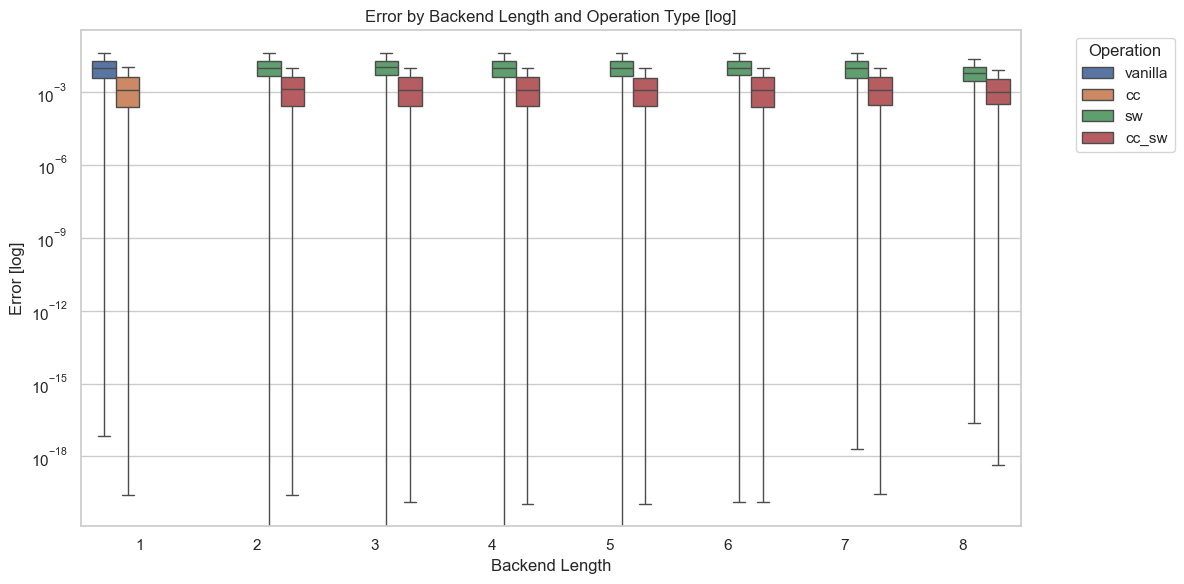

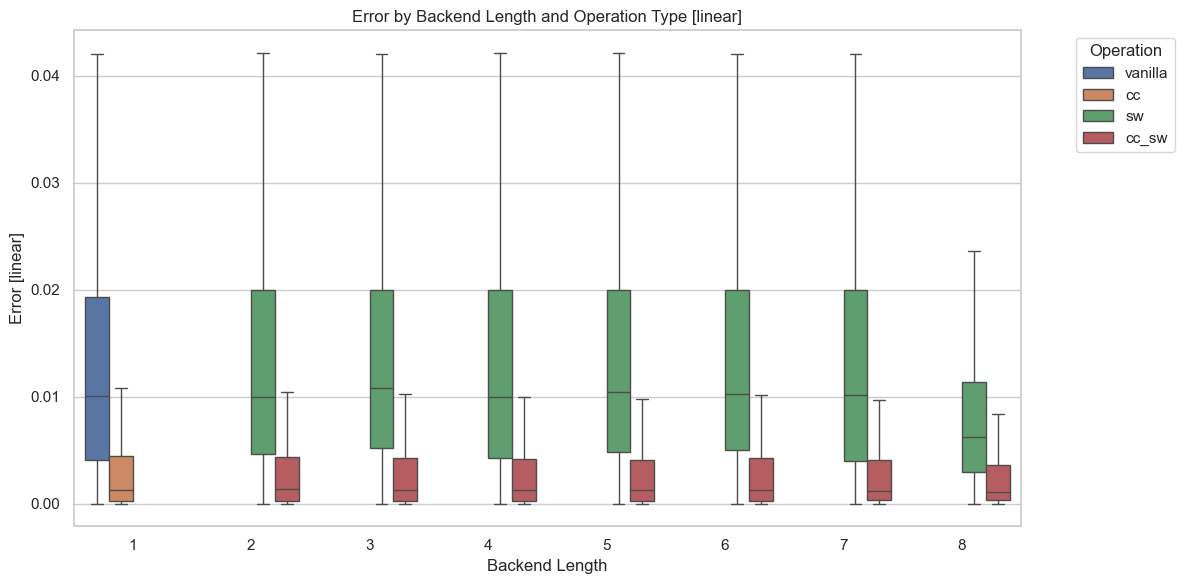

In [8]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='backends_len', y='error', hue='operation', data=df, showfliers=False)

    # Add title and labels
    plt.title(f'Error by Backend Length and Operation Type [{style}]')
    plt.xlabel('Backend Length')
    plt.ylabel(f'Error [{style}]')
    plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc=2)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

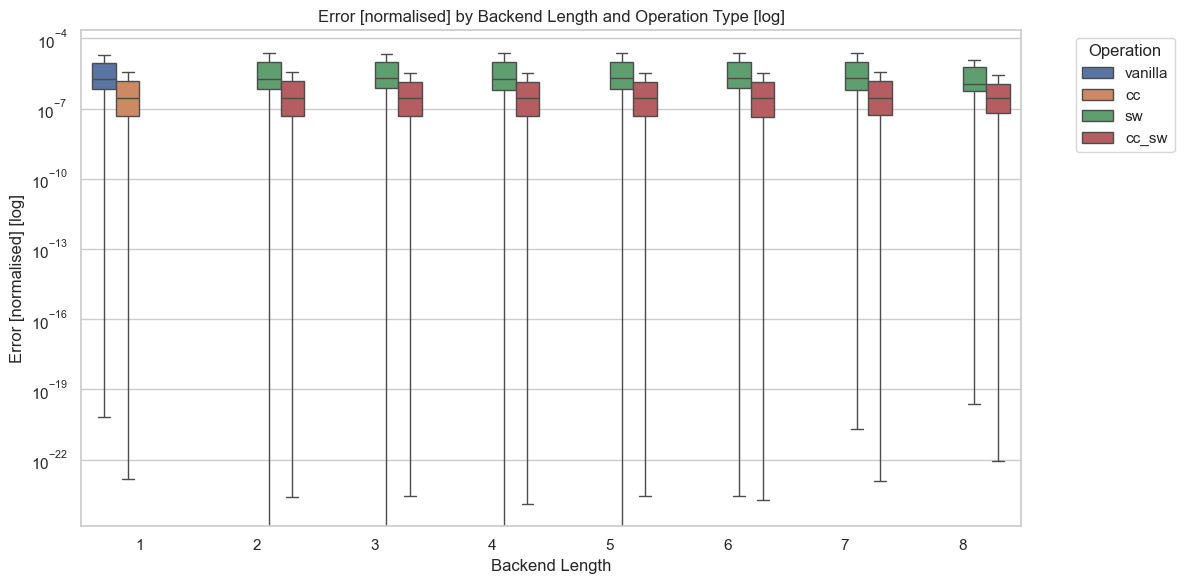

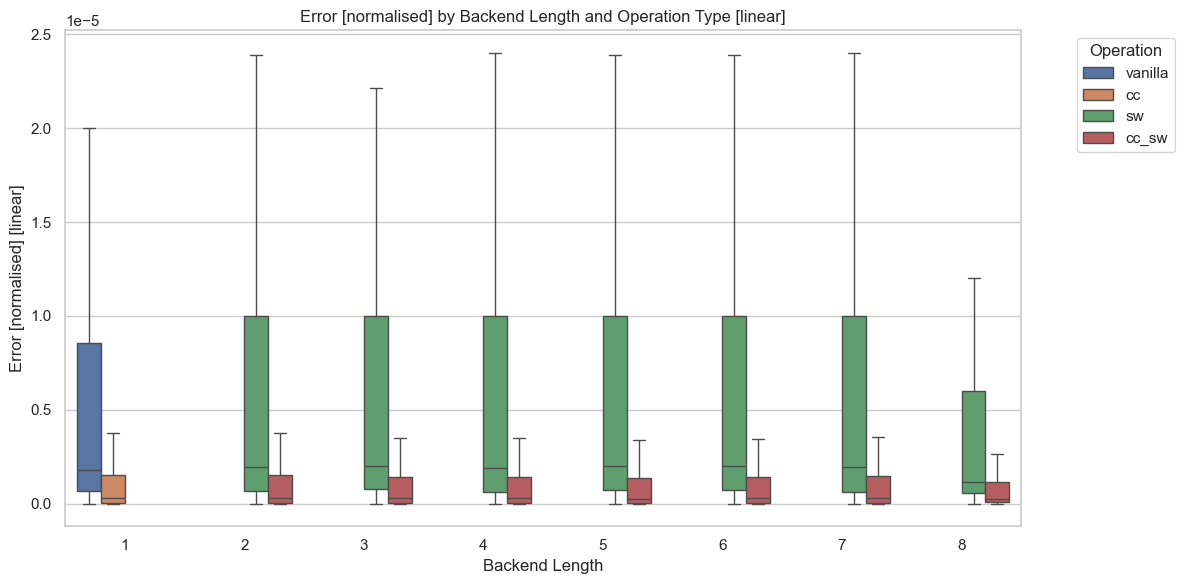

In [9]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='backends_len', y='error_norm', hue='operation', data=df, showfliers=False)

    # Add title and labels
    plt.title(f'Error [normalised] by Backend Length and Operation Type [{style}]')
    plt.xlabel('Backend Length')
    plt.ylabel(f'Error [normalised] [{style}]')
    plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc=2)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

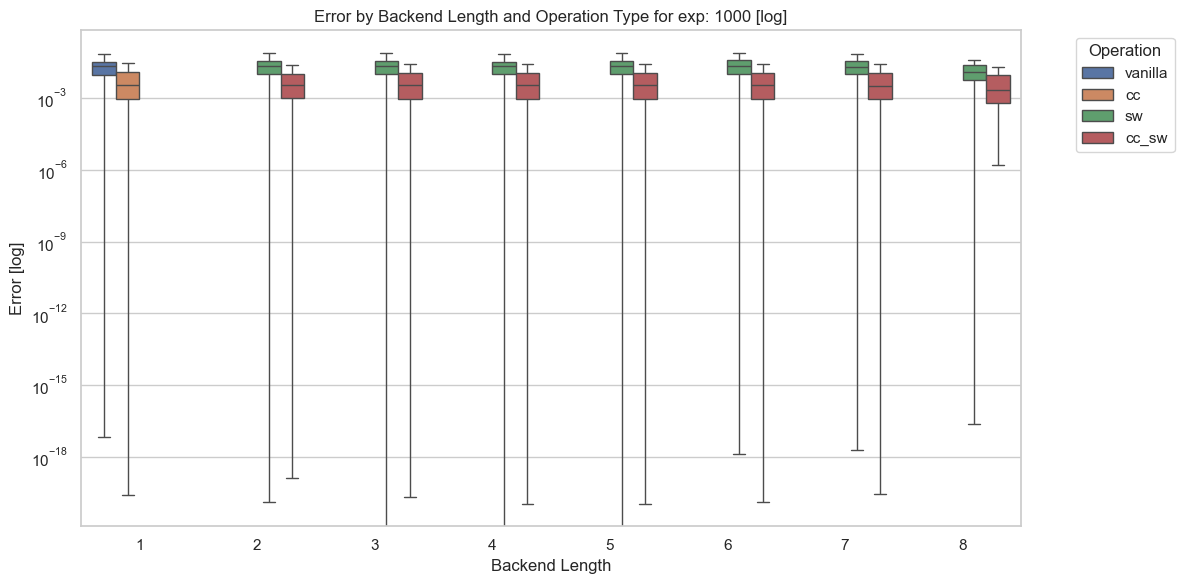

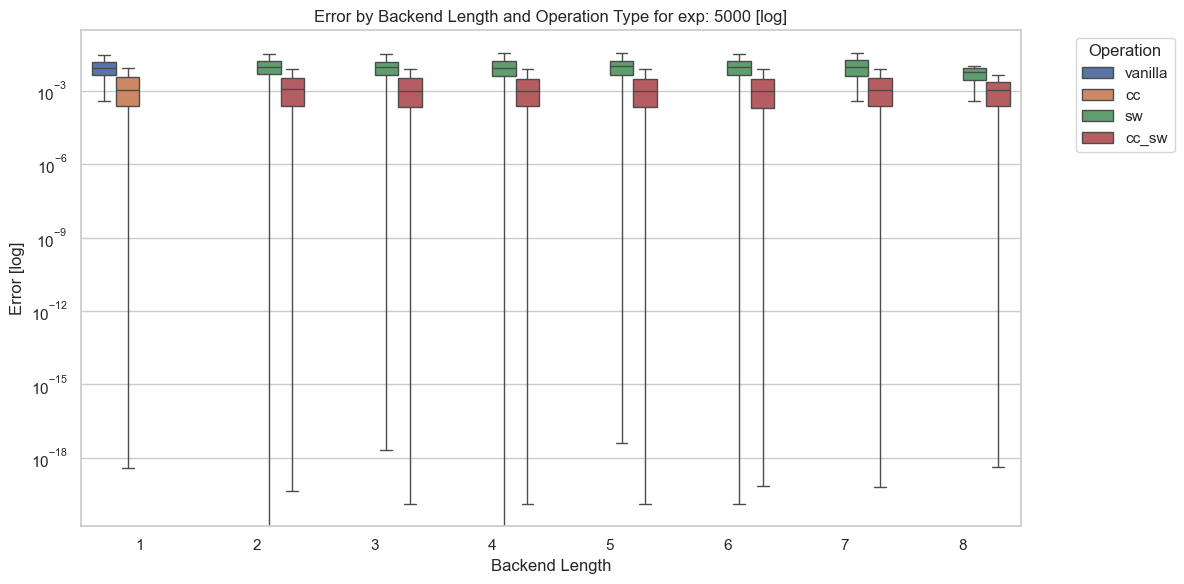

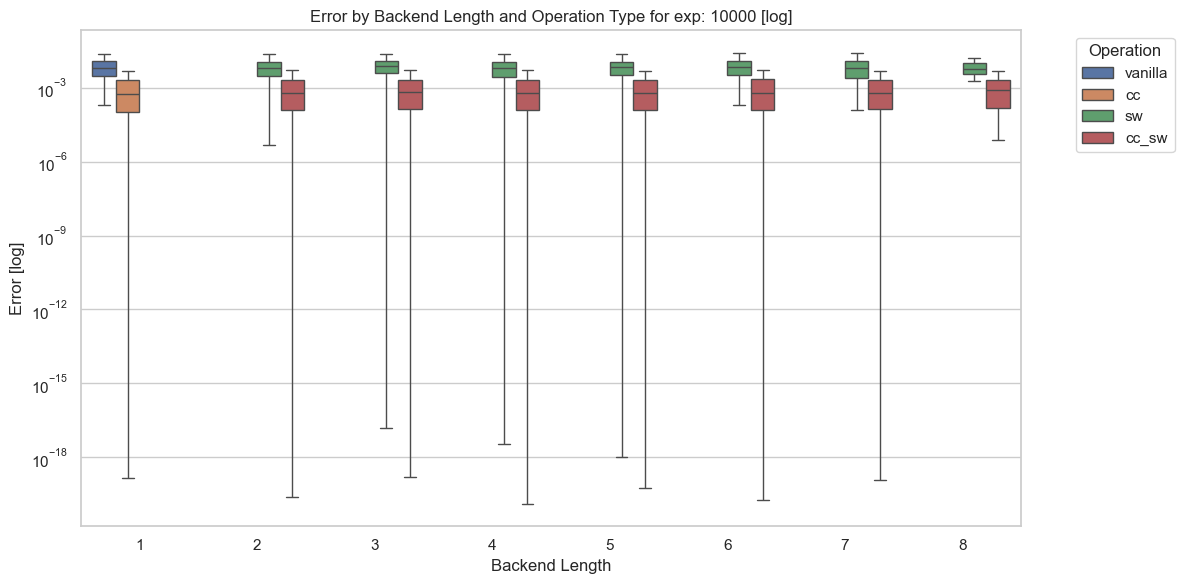

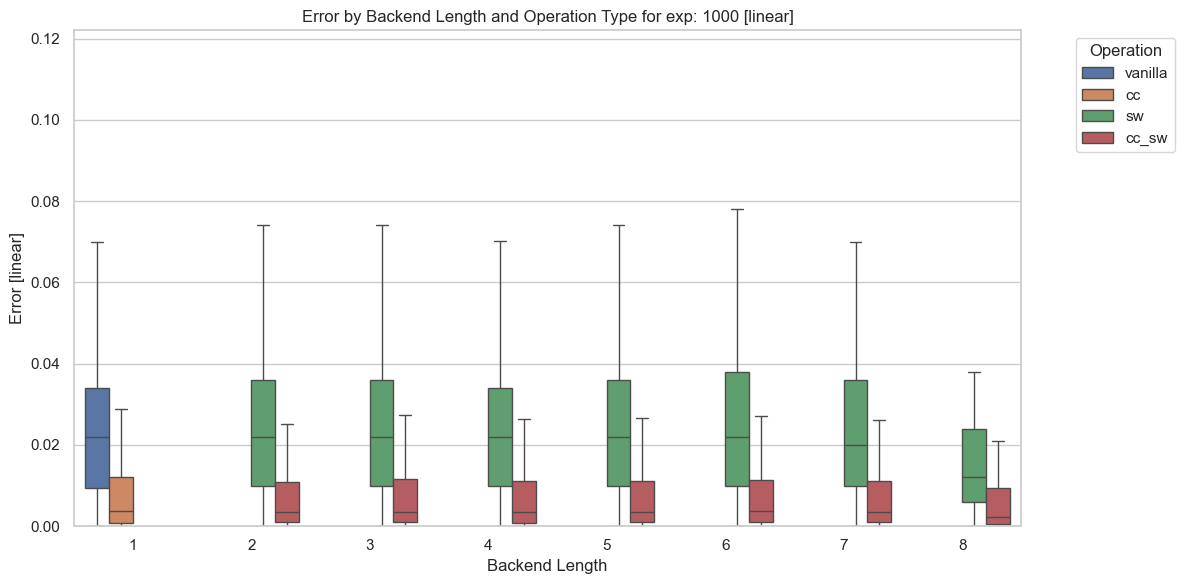

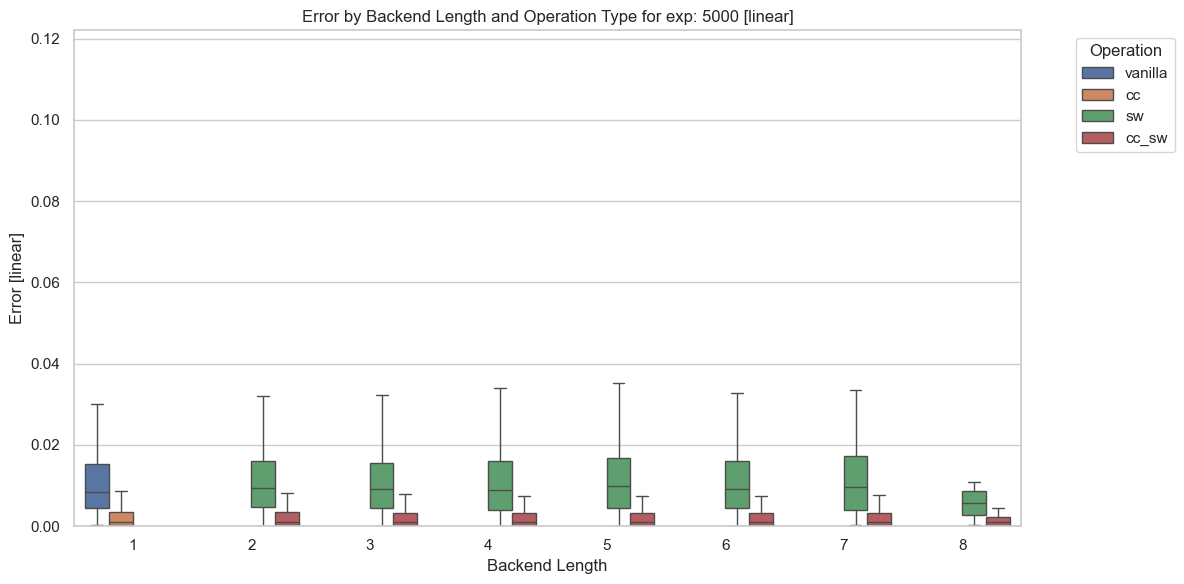

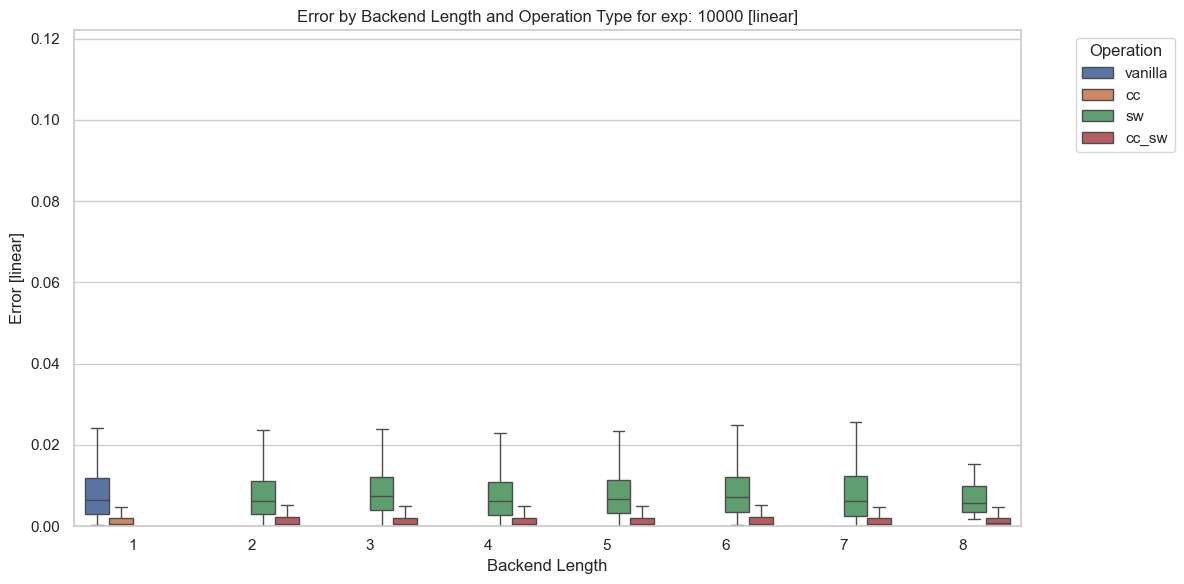

In [10]:
# Compute the global y-axis limits for the 'error' column across the concatenated DataFrame
global_y_min = df['error'].min()
global_y_max = df['error'].max()

# Split the concatenated DataFrame by an attribute; for instance, 'exp'
grouped = df.groupby('shots')

for style in ["log", "linear"]:
    # Iterate over each group and create a boxplot
    for group_name, group_df in grouped:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='backends_len', y='error', hue='operation', data=group_df, showfliers=False)
        if style != "log":
            plt.ylim(global_y_min, global_y_max)
        plt.title(f'Error by Backend Length and Operation Type for exp: {group_name} [{style}]')
        plt.xlabel('Backend Length')
        plt.ylabel(f'Error [{style}]')
        plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.yscale(style)
        plt.tight_layout()
        plt.show()

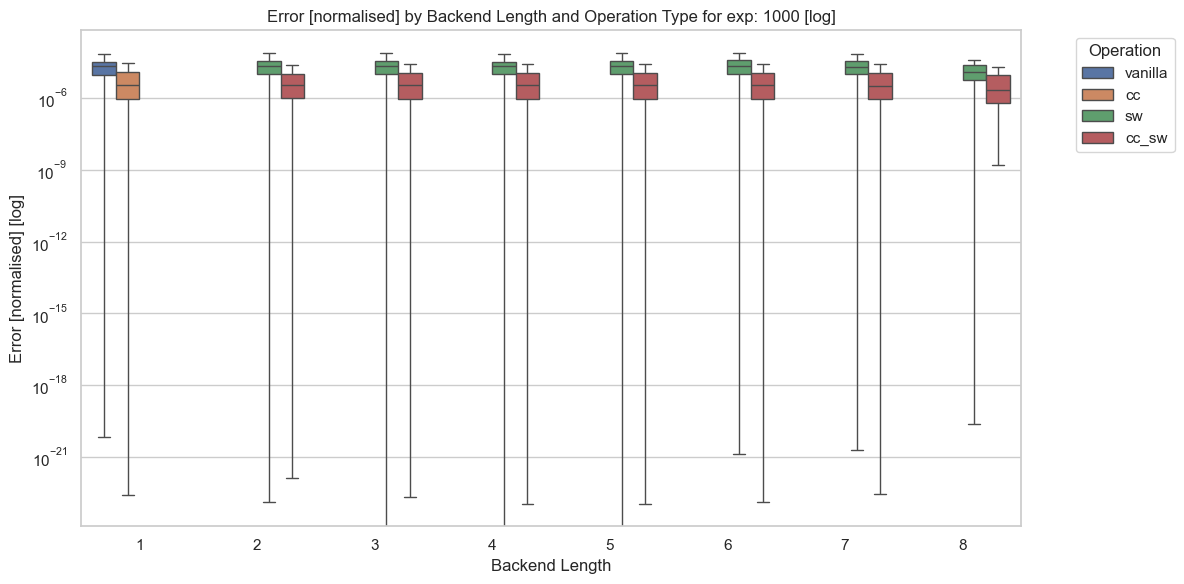

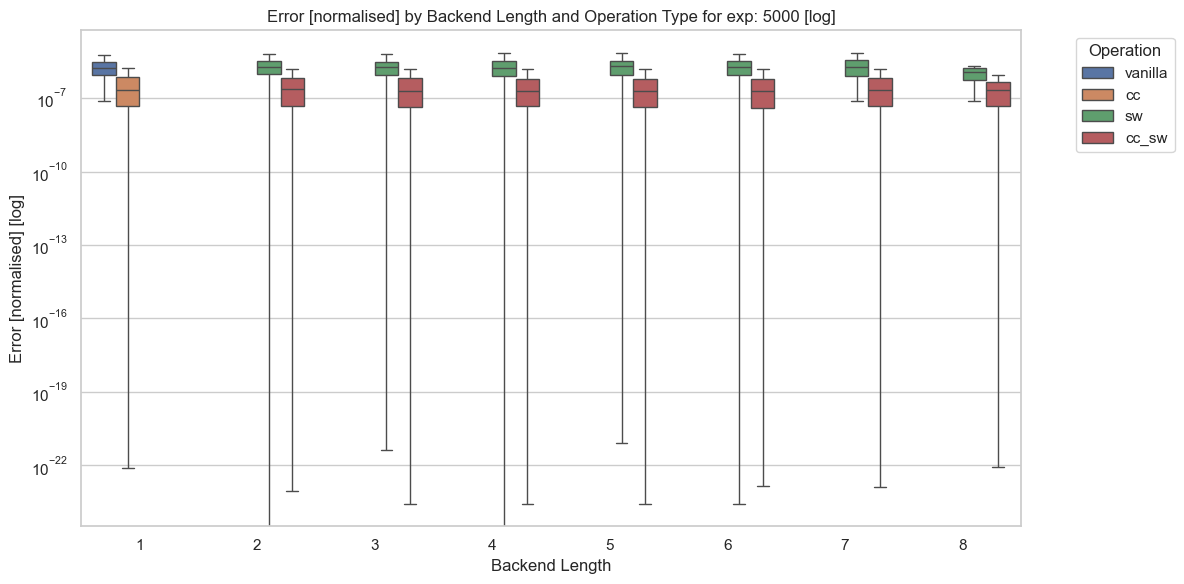

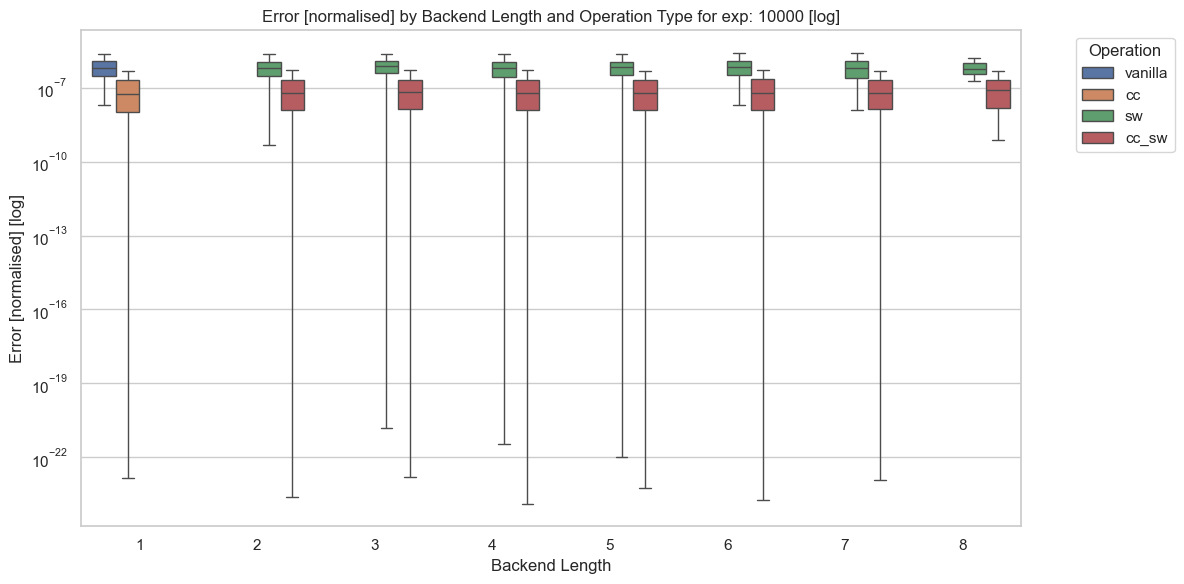

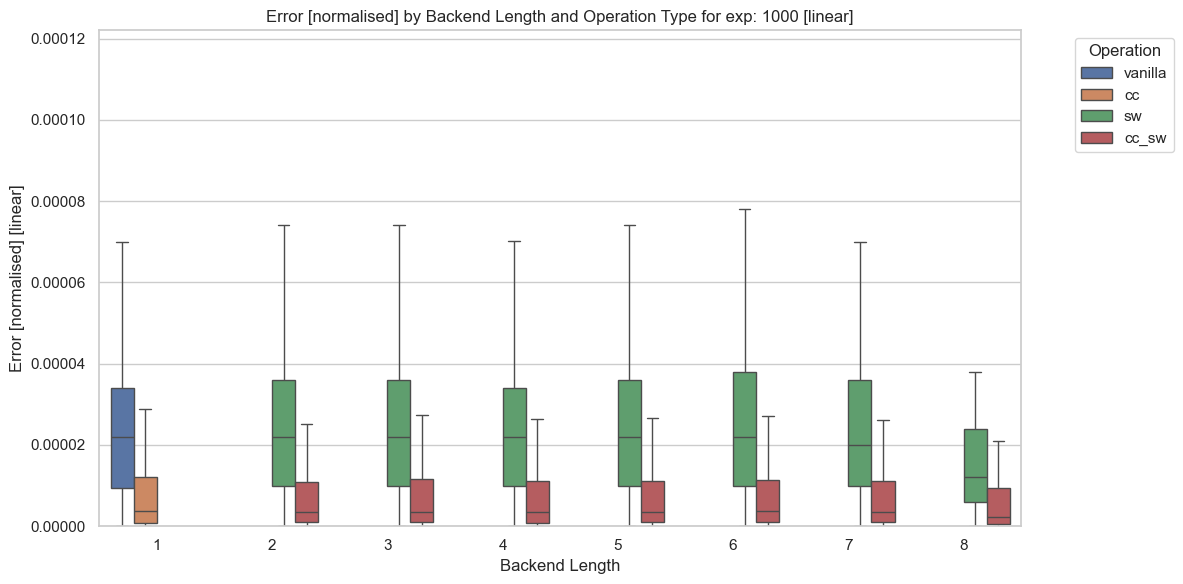

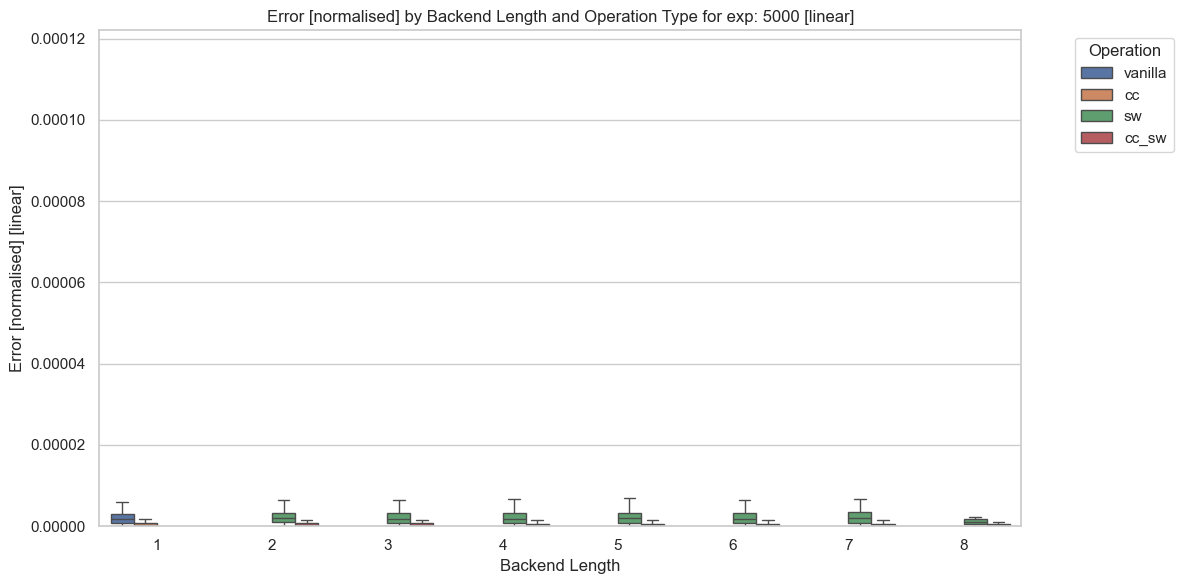

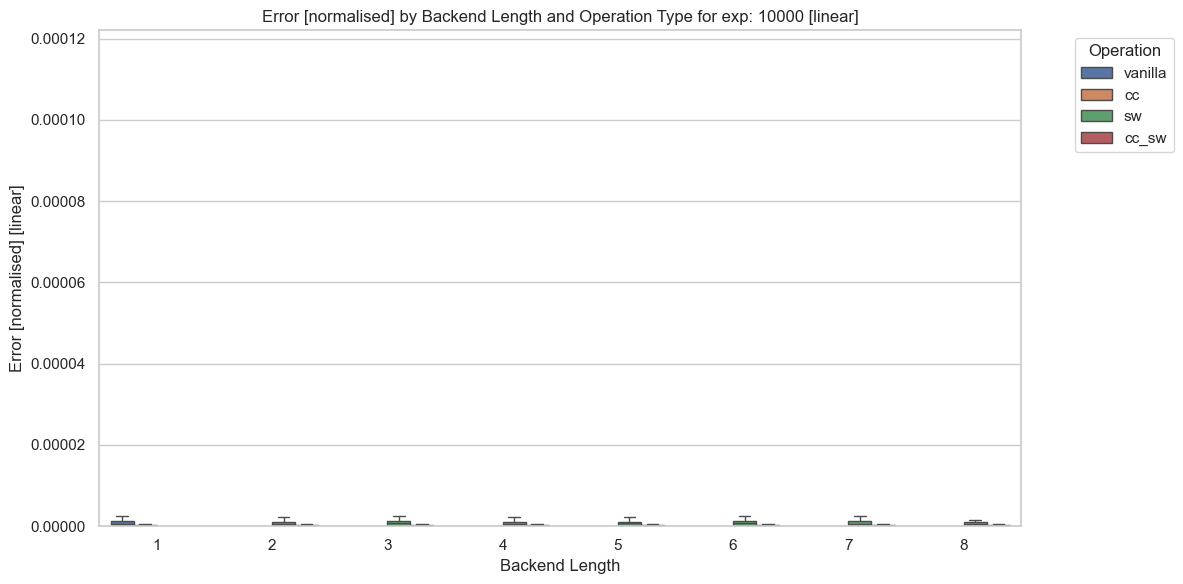

In [11]:
# Compute the global y-axis limits for the 'error' column across the concatenated DataFrame
global_y_min = df['error_norm'].min()
global_y_max = df['error_norm'].max()

# Split the concatenated DataFrame by an attribute; for instance, 'exp'
grouped = df.groupby('shots')

for style in ["log", "linear"]:
    # Iterate over each group and create a boxplot
    for group_name, group_df in grouped:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='backends_len', y='error_norm', hue='operation', data=group_df, showfliers=False)
        if style != "log":
            plt.ylim(global_y_min, global_y_max)
        plt.title(f'Error [normalised] by Backend Length and Operation Type for exp: {group_name} [{style}]')
        plt.xlabel('Backend Length')
        plt.ylabel(f'Error [normalised] [{style}]')
        plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.yscale(style)
        plt.tight_layout()
        plt.show()

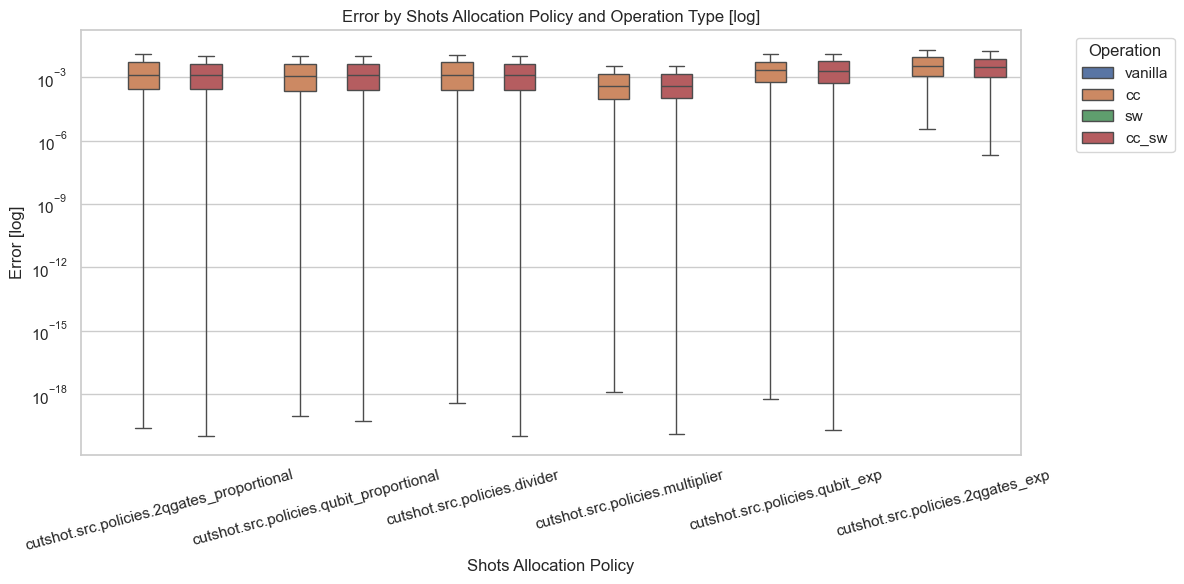

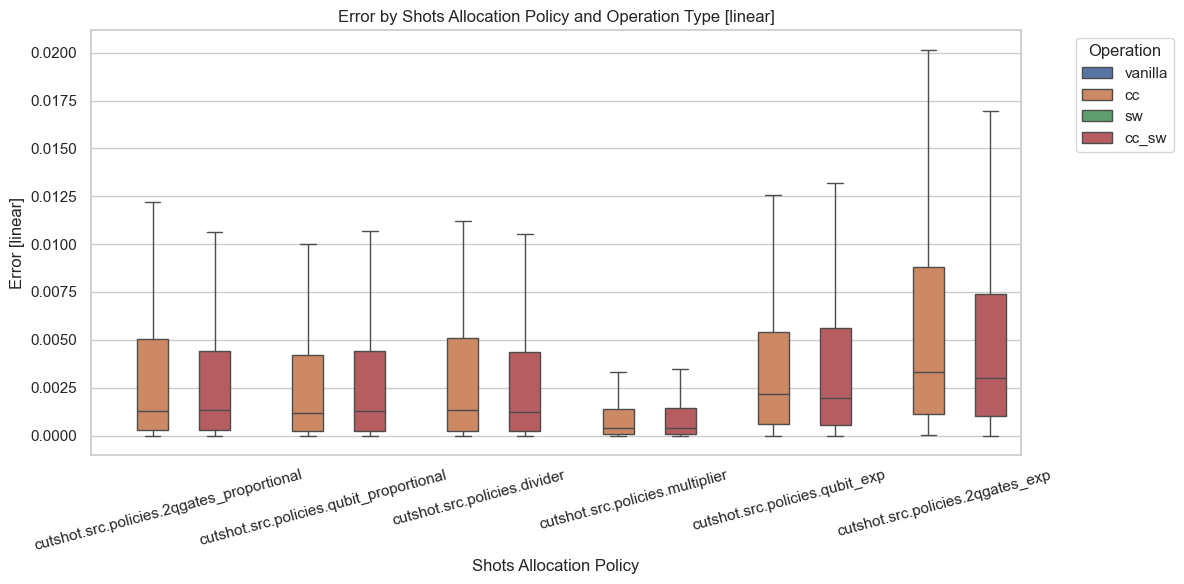

In [12]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='error', hue='operation', data=df, showfliers=False)

    # Add title and labels
    plt.title(f'Error by Shots Allocation Policy and Operation Type [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Error [{style}]')
    plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

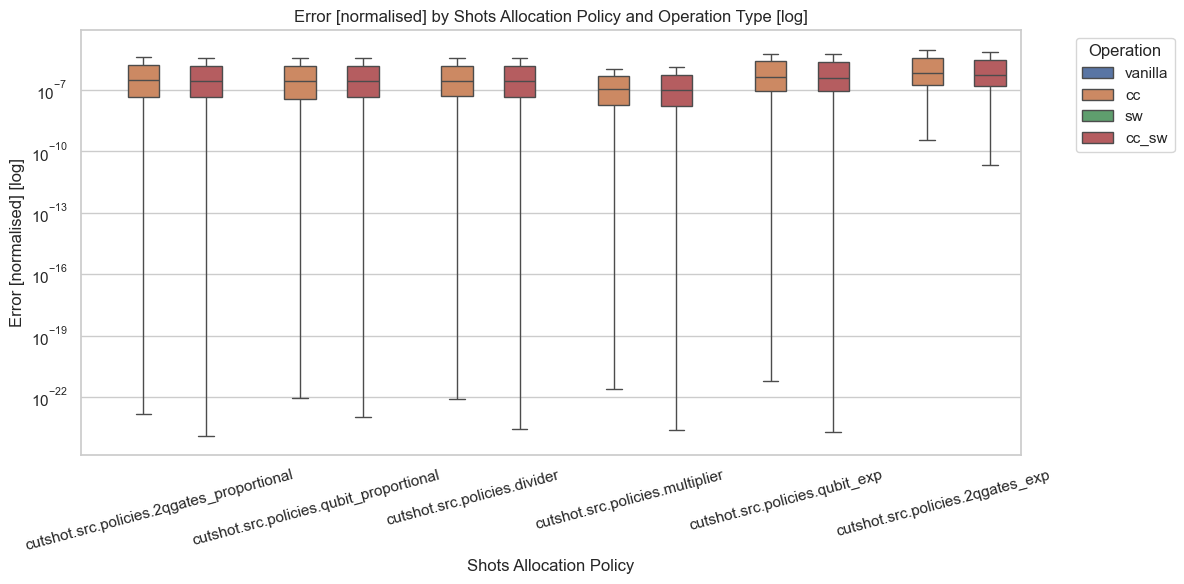

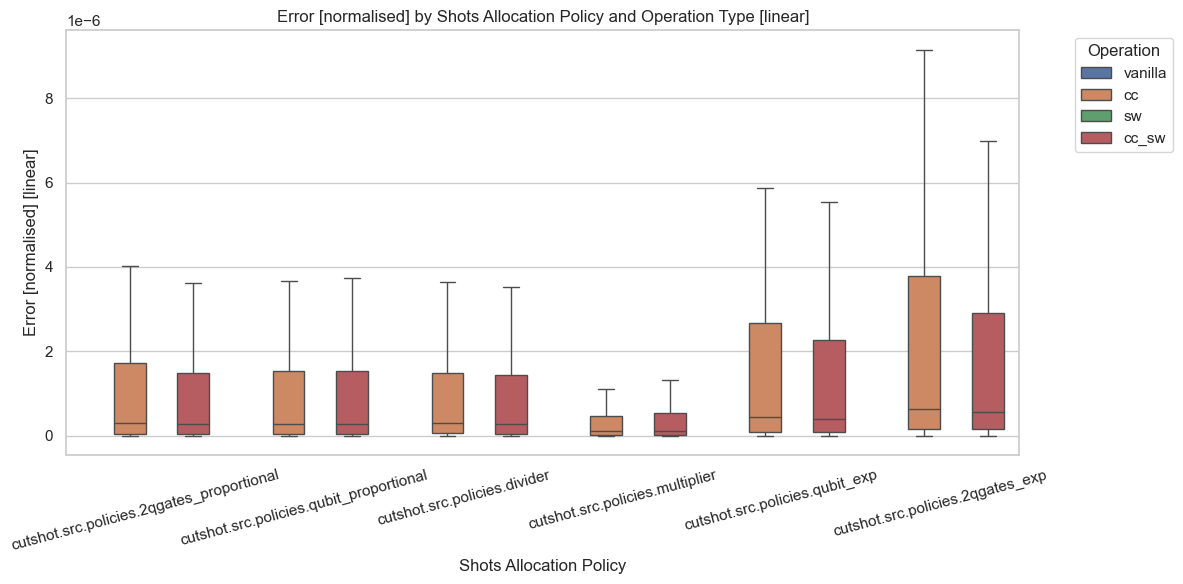

In [13]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='error_norm', hue='operation', data=df, showfliers=False)

    # Add title and labels
    plt.title(f'Error [normalised] by Shots Allocation Policy and Operation Type [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Error [normalised] [{style}]')
    plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

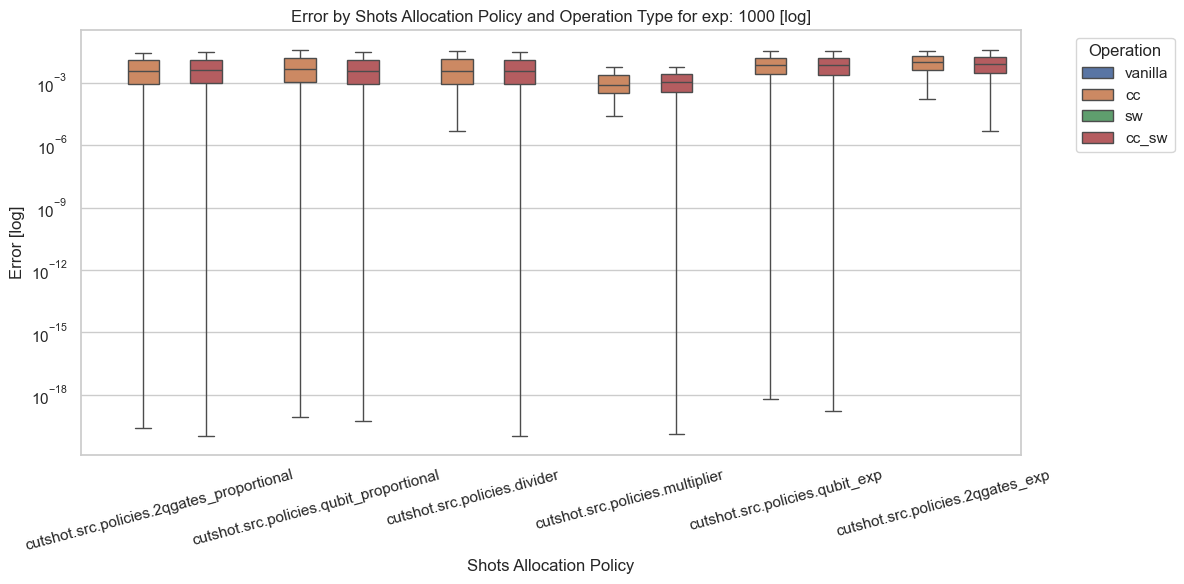

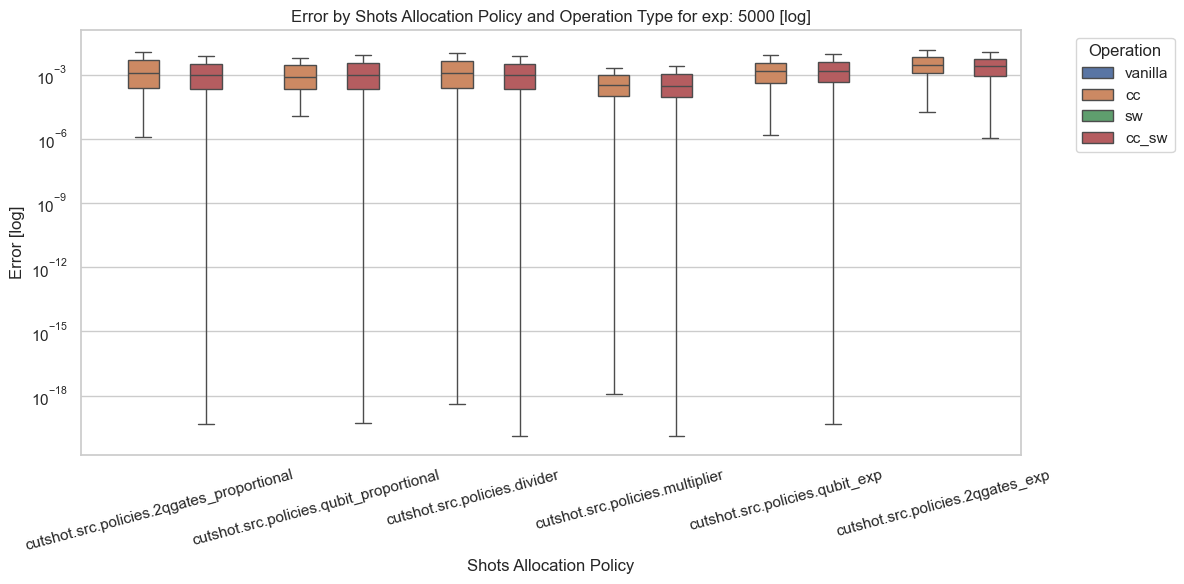

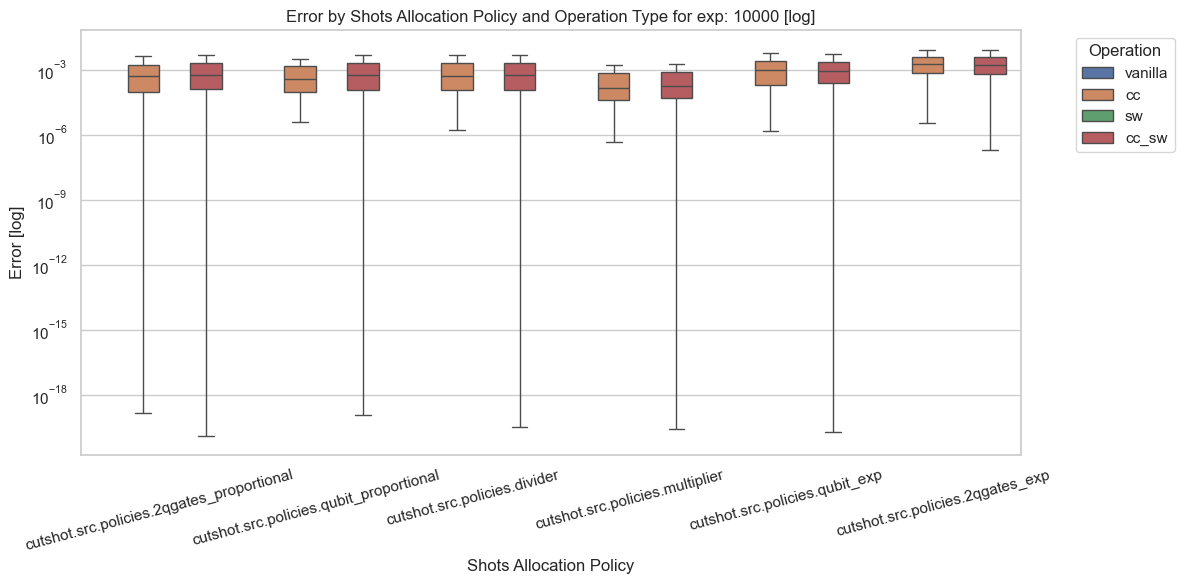

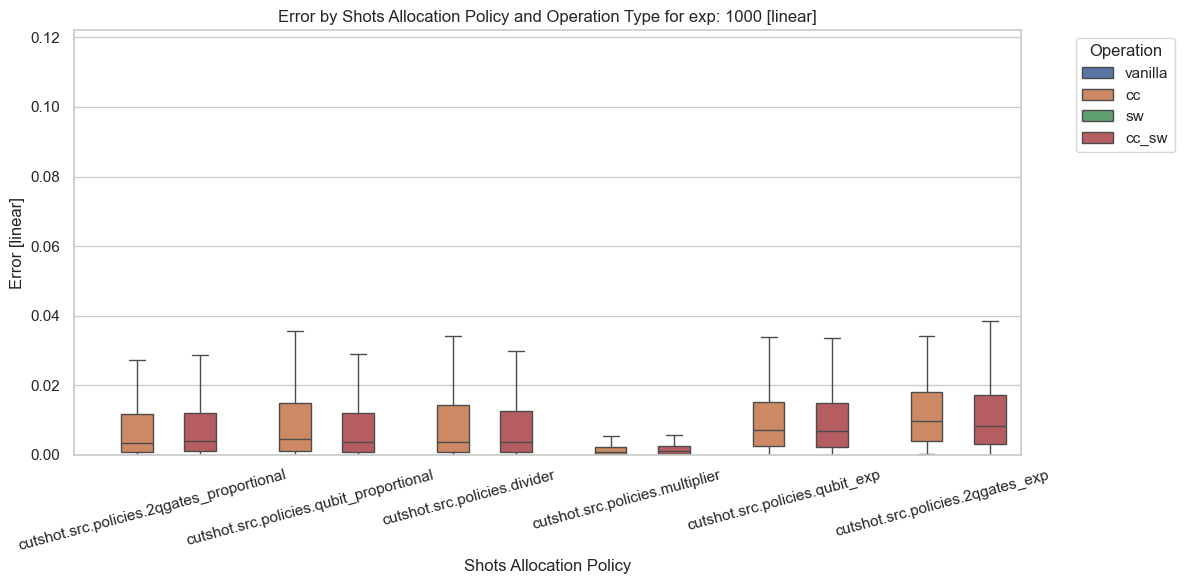

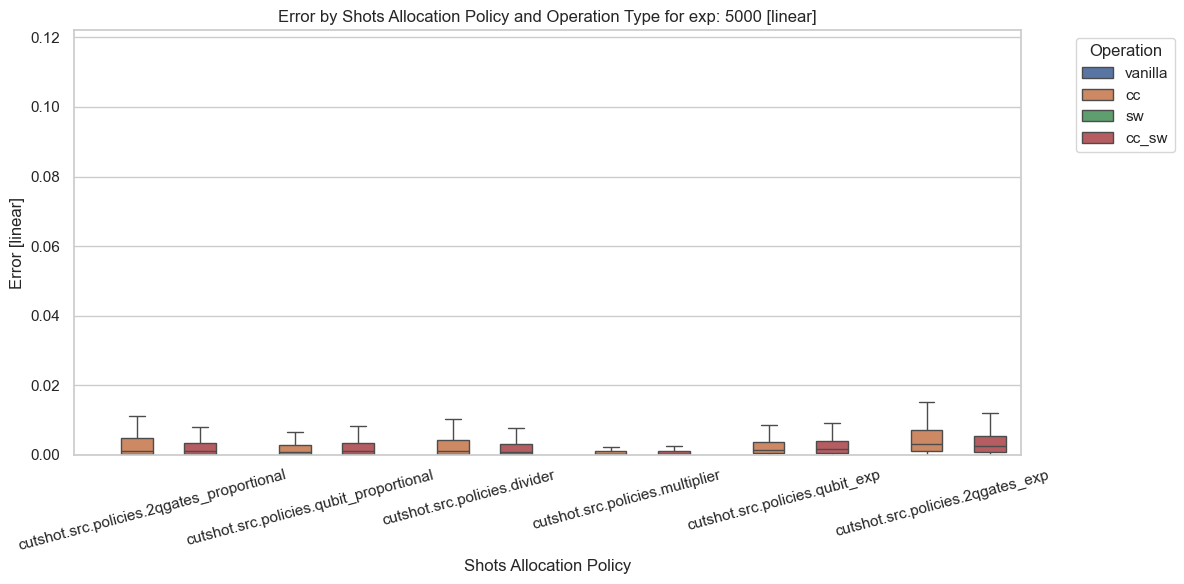

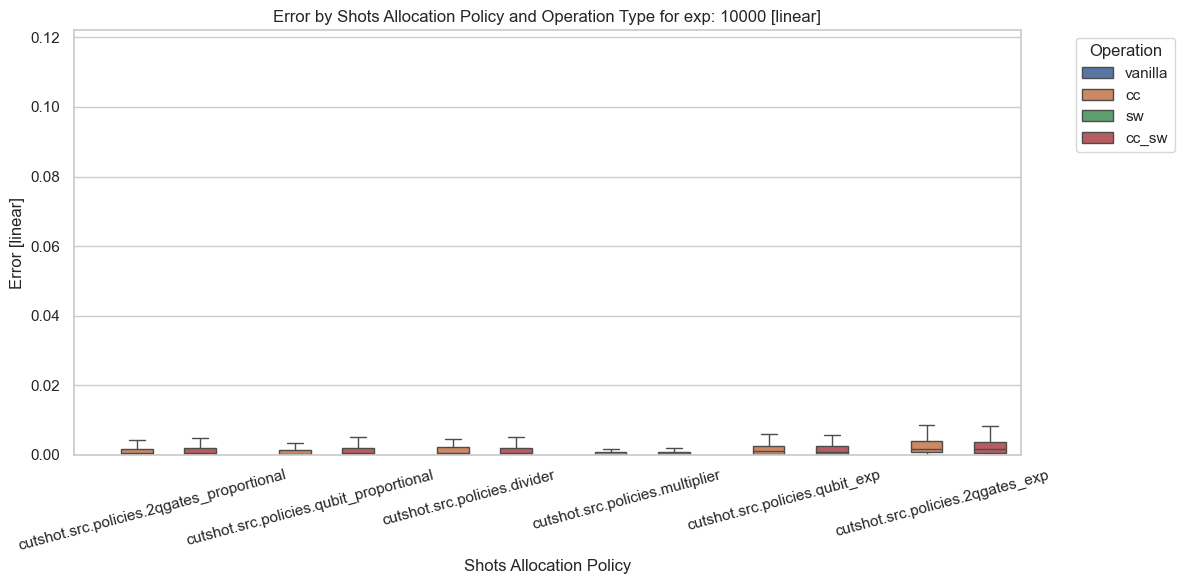

In [14]:
# Compute the global y-axis limits for the 'error' column across the concatenated DataFrame
global_y_min = df['error'].min()
global_y_max = df['error'].max()

# Split the concatenated DataFrame by an attribute; for instance, 'exp'
grouped = df.groupby('shots')

for style in ["log", "linear"]:
# Iterate over each group and create a boxplot
    for group_name, group_df in grouped:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='shots_allocation', y='error', hue='operation', data=group_df, showfliers=False)
        if style != "log":
            plt.ylim(global_y_min, global_y_max)    
        plt.title(f'Error by Shots Allocation Policy and Operation Type for exp: {group_name} [{style}]')
        plt.xlabel('Shots Allocation Policy')
        plt.ylabel(f'Error [{style}]')
        plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc='upper left')
        # rotate vertical labels
        plt.xticks(rotation=15)
        plt.yscale(style)
        plt.tight_layout()
        plt.show()

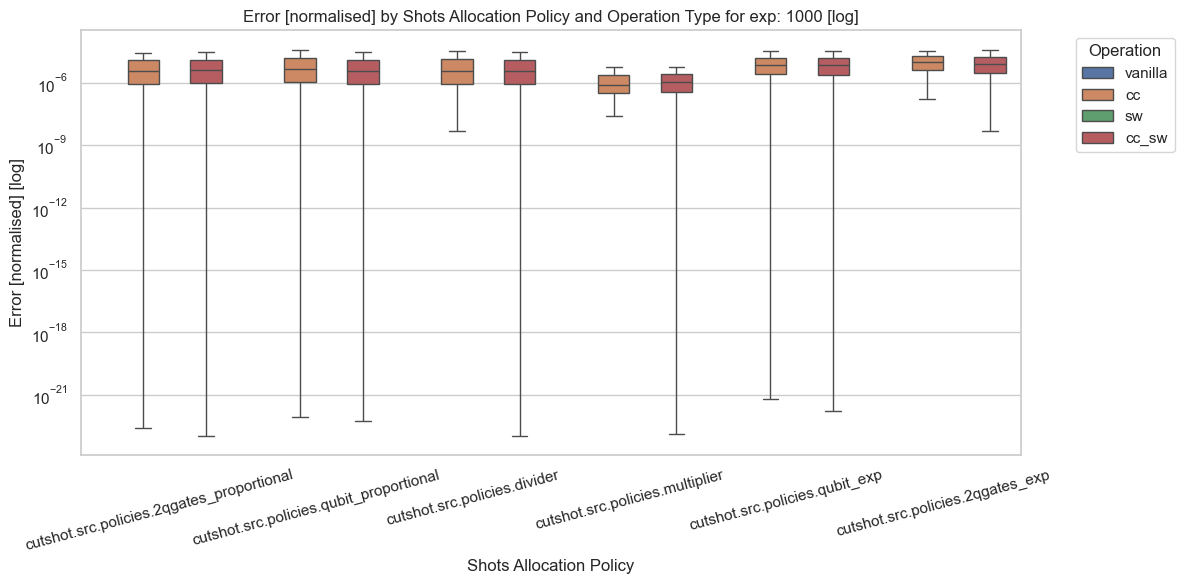

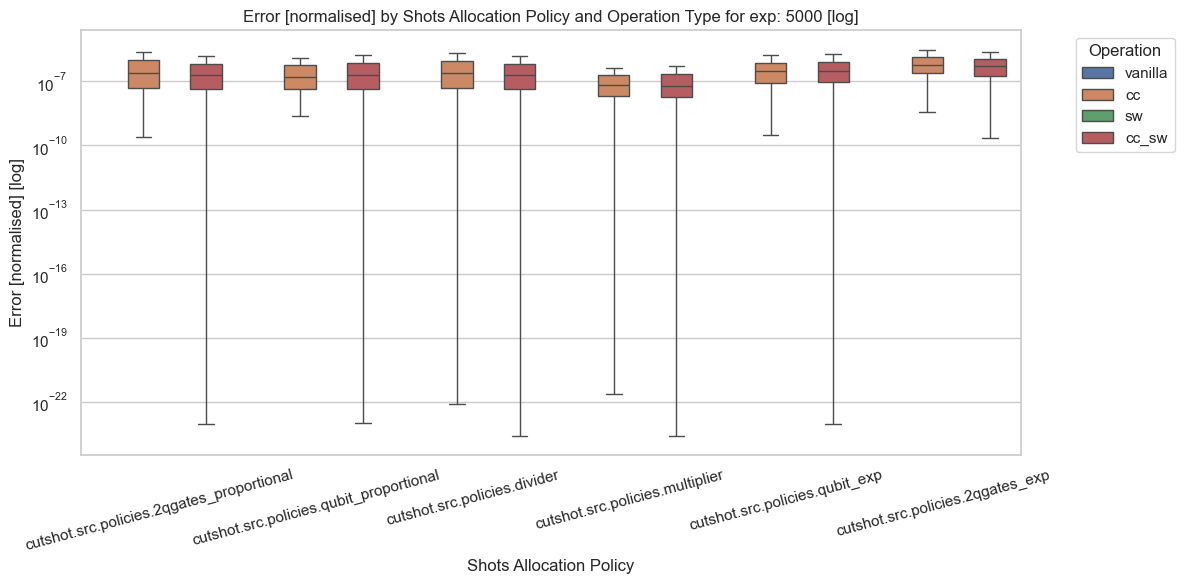

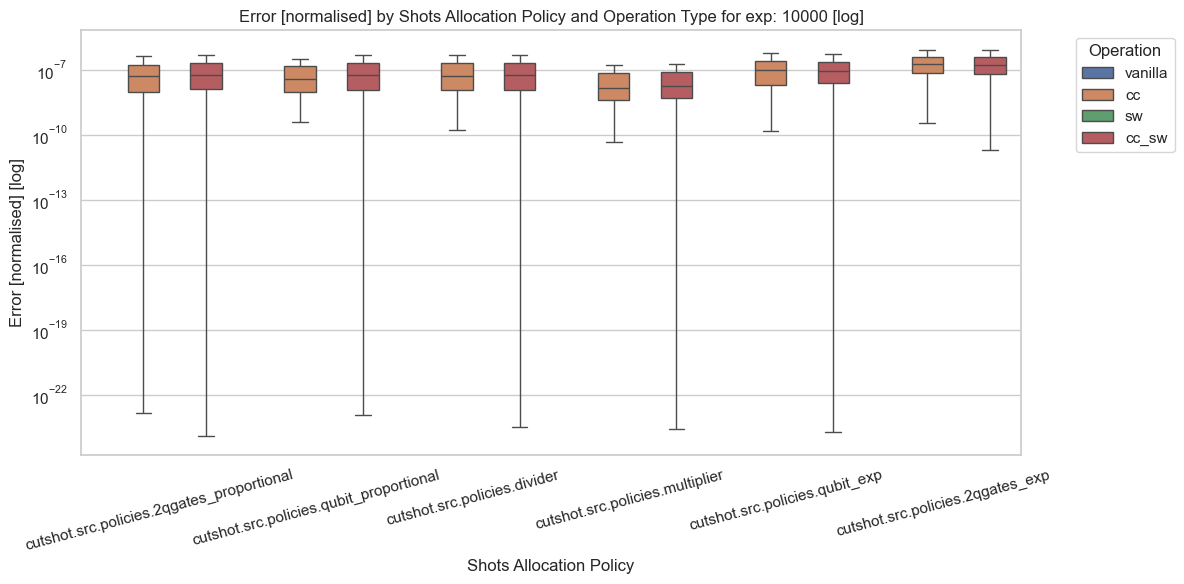

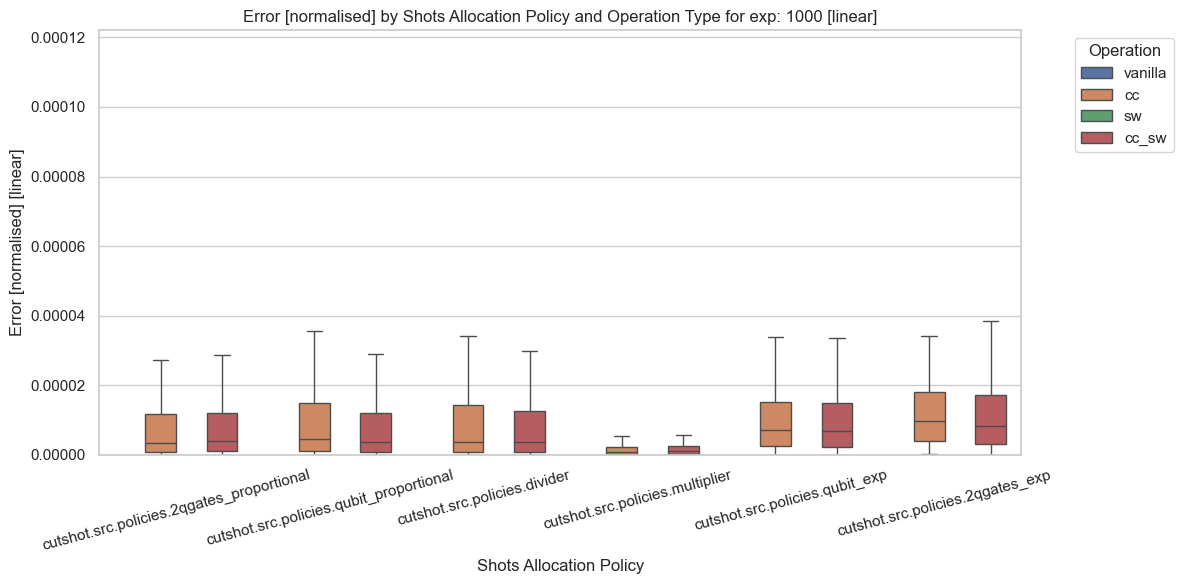

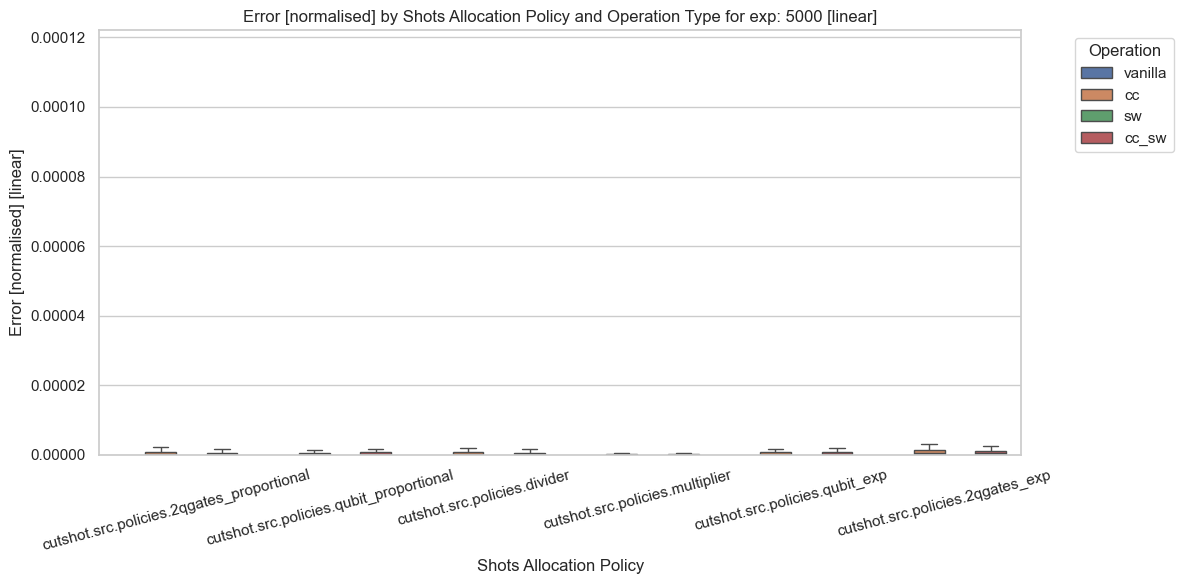

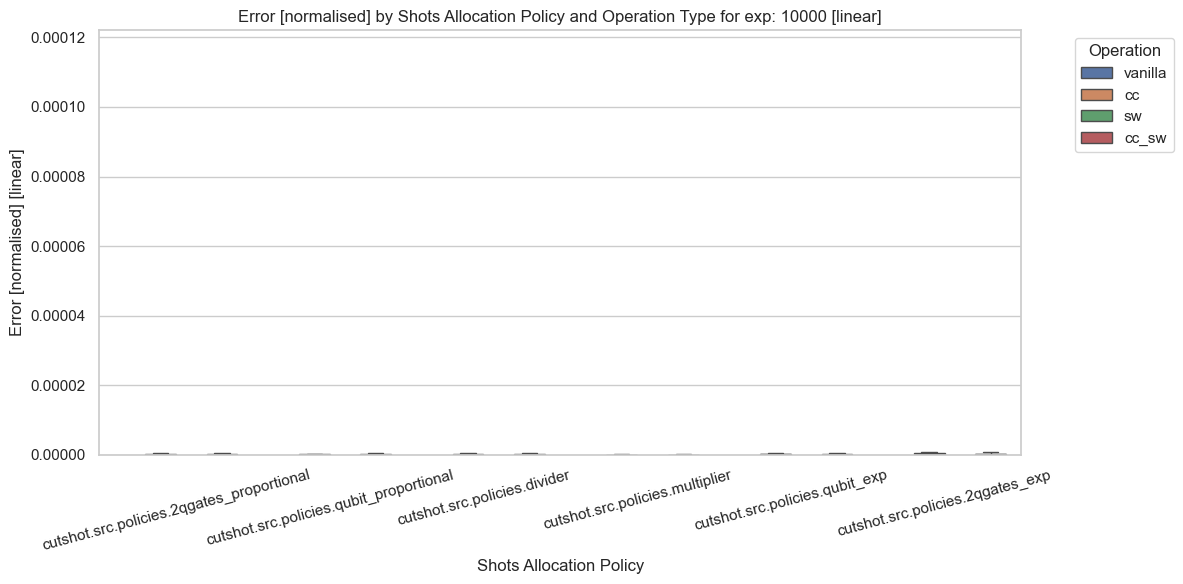

In [15]:
# Compute the global y-axis limits for the 'error' column across the concatenated DataFrame
global_y_min = df['error_norm'].min()
global_y_max = df['error_norm'].max()

# Split the concatenated DataFrame by an attribute; for instance, 'exp'
grouped = df.groupby('shots')

for style in ["log", "linear"]:
# Iterate over each group and create a boxplot
    for group_name, group_df in grouped:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='shots_allocation', y='error_norm', hue='operation', data=group_df, showfliers=False)
        if style != "log":
            plt.ylim(global_y_min, global_y_max)
        plt.title(f'Error [normalised] by Shots Allocation Policy and Operation Type for exp: {group_name} [{style}]')
        plt.xlabel('Shots Allocation Policy')
        plt.ylabel(f'Error [normalised] [{style}]')
        plt.legend(title='Operation', bbox_to_anchor=(1.05, 1), loc='upper left')
        # rotate vertical labels
        plt.xticks(rotation=15)
        plt.yscale(style)
        plt.tight_layout()
        plt.show()

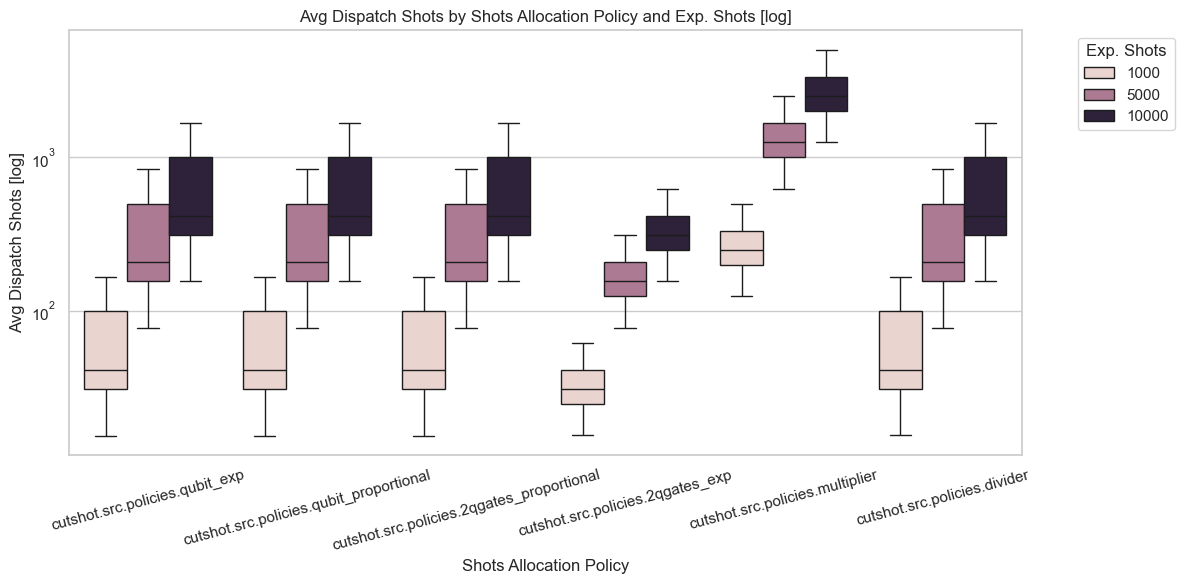

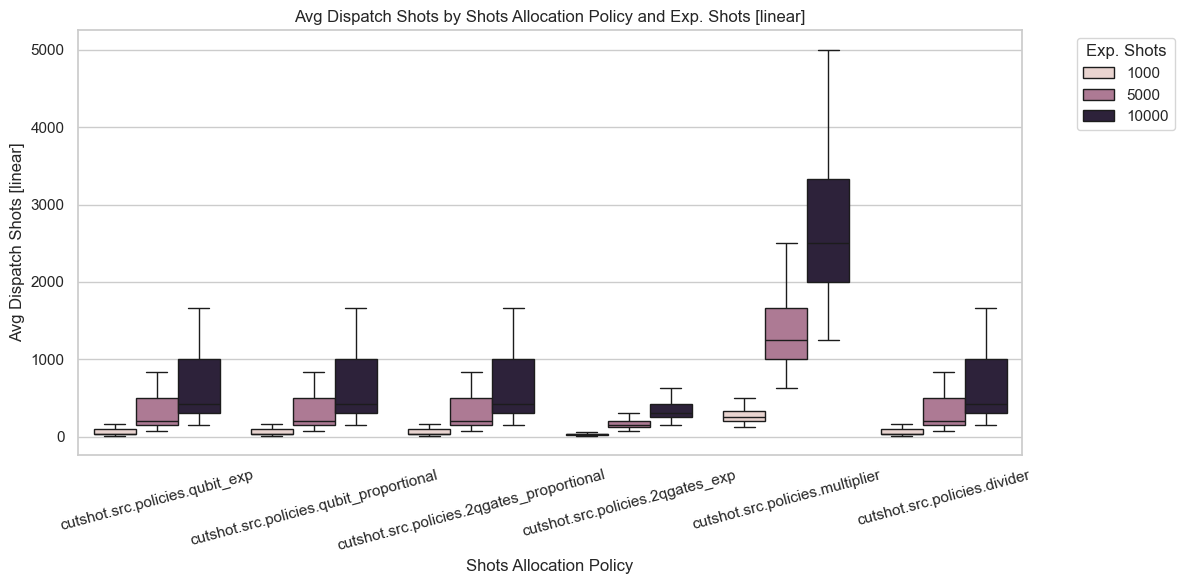

In [16]:

for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='avg_shots', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Avg Dispatch Shots by Shots Allocation Policy and Exp. Shots [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Avg Dispatch Shots [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

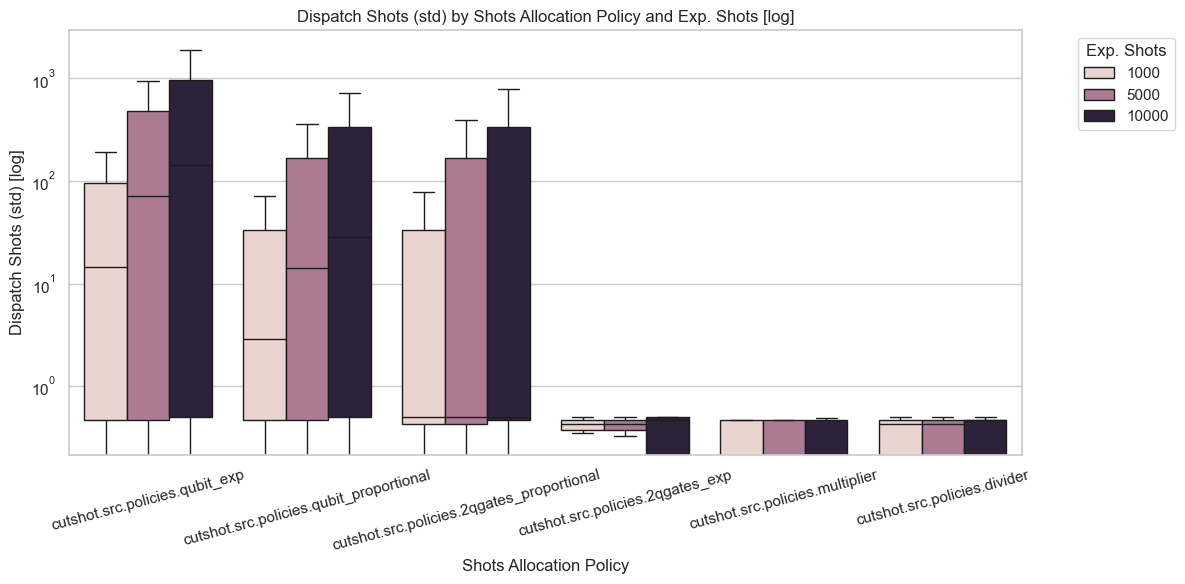

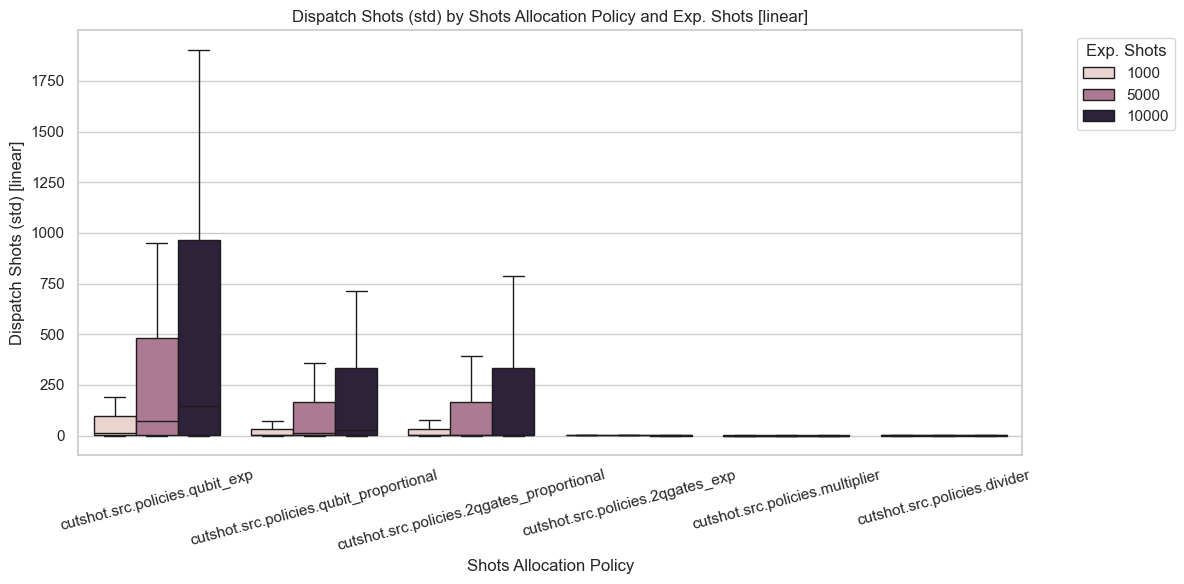

In [17]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='std_shots', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Dispatch Shots (std) by Shots Allocation Policy and Exp. Shots [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Dispatch Shots (std) [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

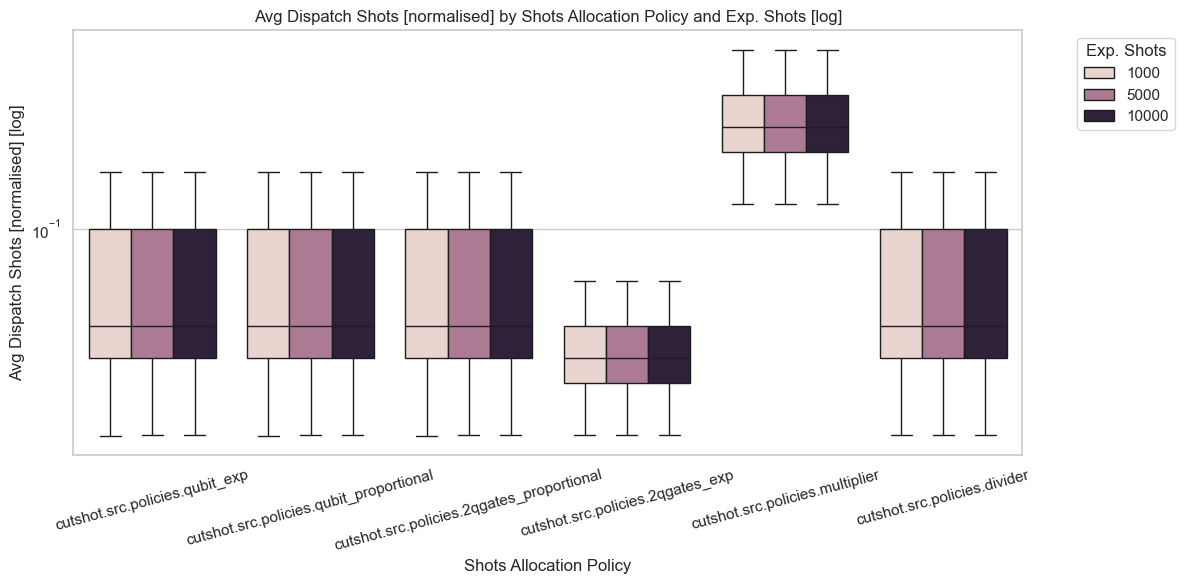

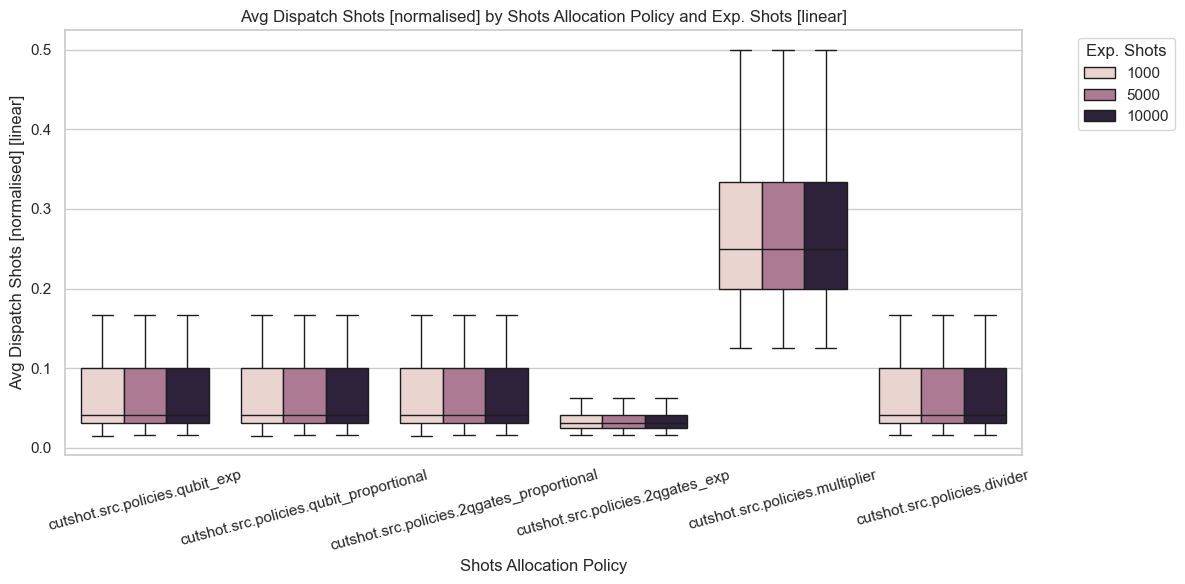

In [18]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='avg_shots_norm', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Avg Dispatch Shots [normalised] by Shots Allocation Policy and Exp. Shots [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Avg Dispatch Shots [normalised] [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)

    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

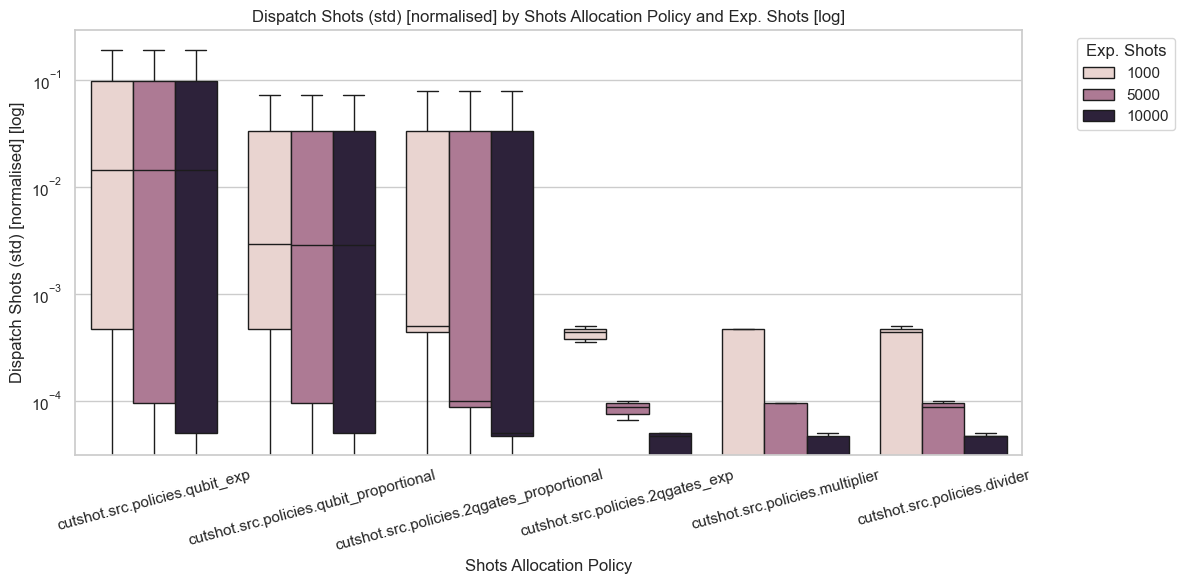

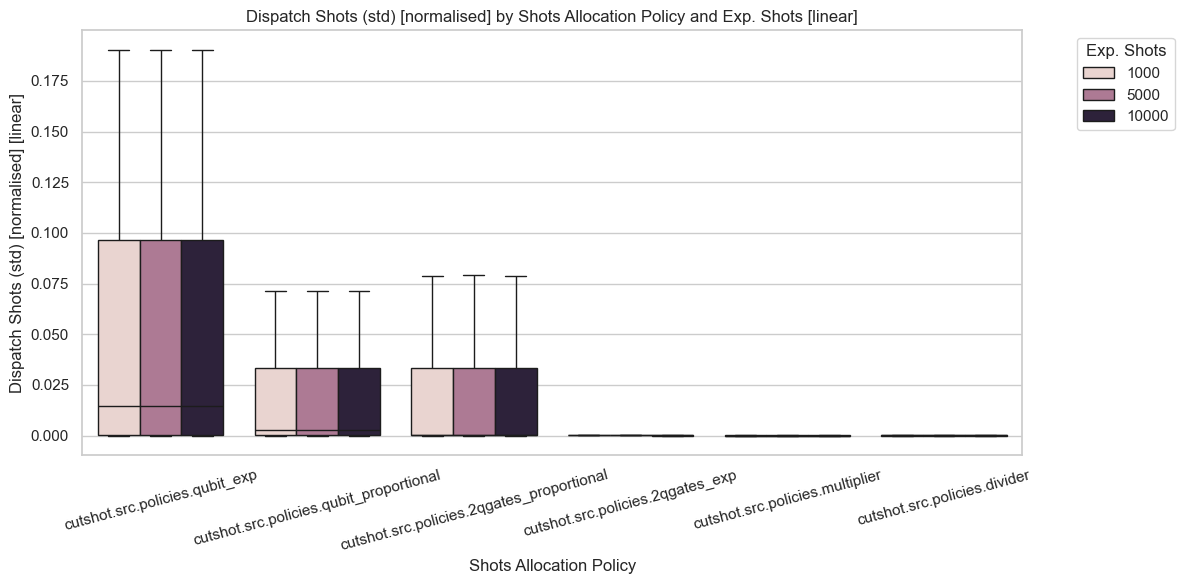

In [19]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='std_shots_norm', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Dispatch Shots (std) [normalised] by Shots Allocation Policy and Exp. Shots [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Dispatch Shots (std) [normalised] [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)

    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

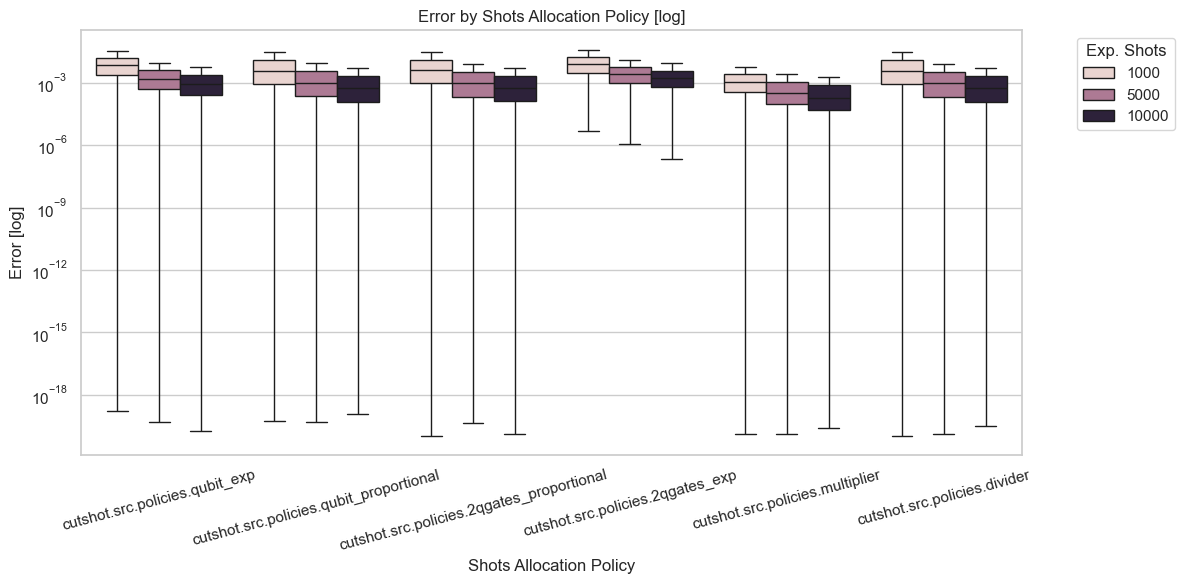

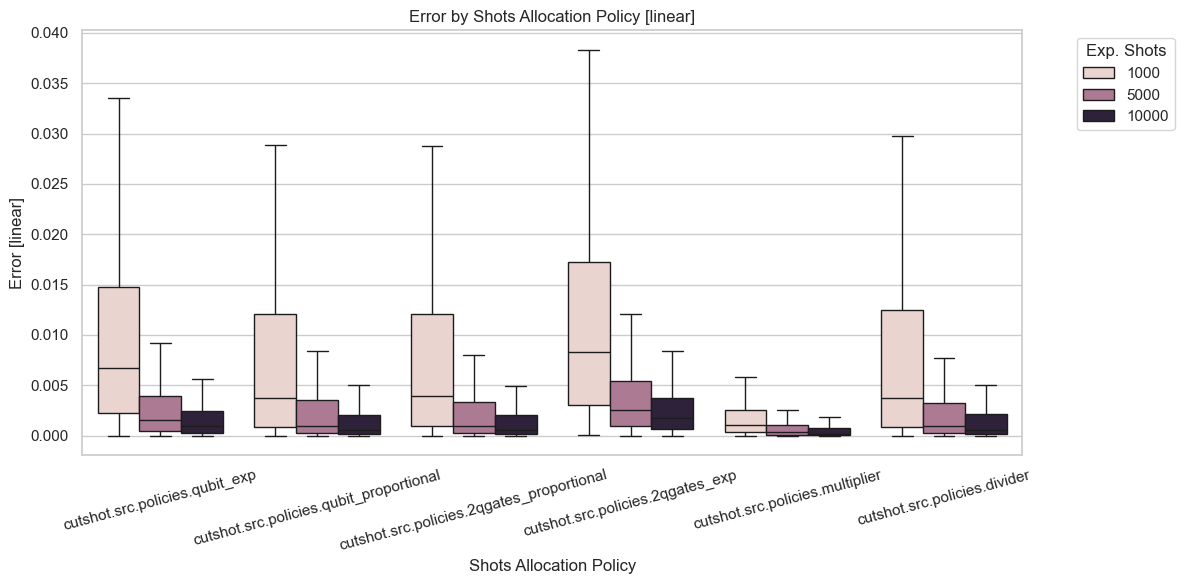

In [20]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='error', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Error by Shots Allocation Policy [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Error [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)
    
    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()

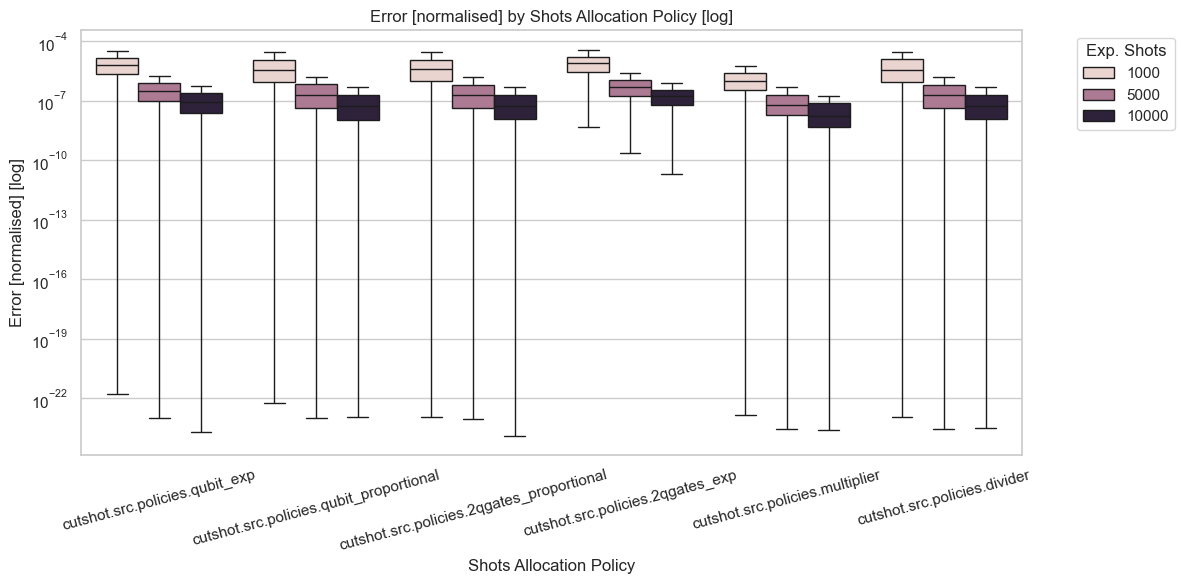

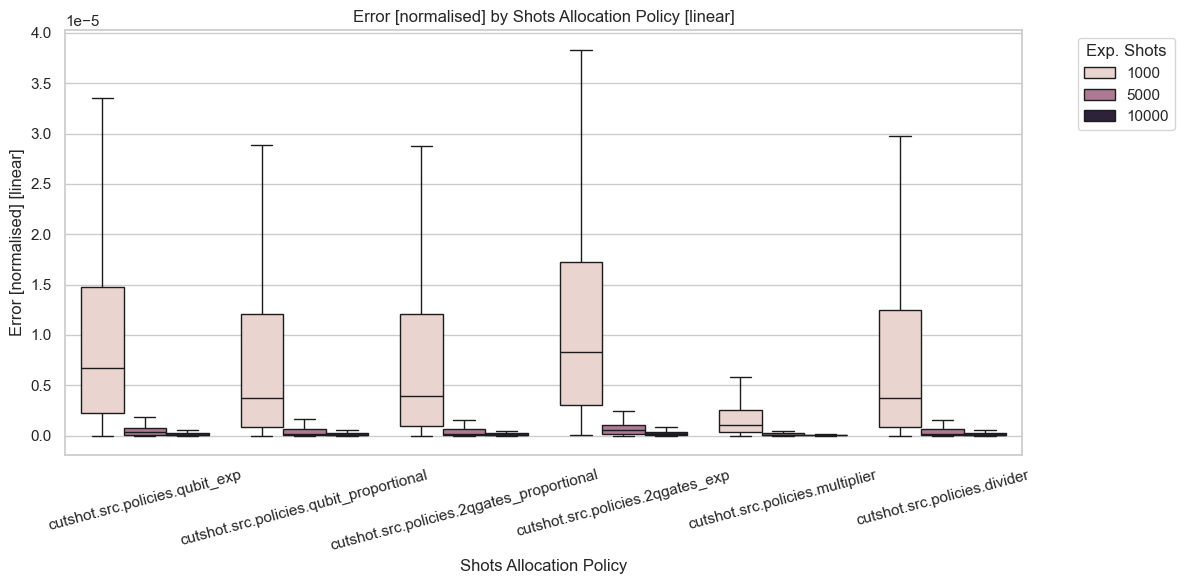

In [21]:
for style in ["log", "linear"]:
    # Set the visual style
    sns.set_theme(style="whitegrid")

    _df = df[df['operation'] == 'cc_sw']

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='shots_allocation', y='error_norm', hue='shots', data=_df, showfliers=False)

    # Add title and labels
    plt.title(f'Error [normalised] by Shots Allocation Policy [{style}]')
    plt.xlabel('Shots Allocation Policy')
    plt.ylabel(f'Error [normalised] [{style}]')
    plt.legend(title='Exp. Shots', bbox_to_anchor=(1.05, 1), loc=2)

    # rotate vertical labels
    plt.xticks(rotation=15)

    plt.yscale(style)

    # Display the plot
    plt.tight_layout()
    plt.show()